# Projekt UMA - Natalia Jaśkowska

# Temat projektu
Tematem projektu jest implementacja zmodyfikowanego algorytmu generowania lasu losowego klasyfikacji, gdzie do generowania kolejnych drzew wykorzystane są częściej elementy zbioru uczącego, na których model popełnia większe błędy.

# Zrealizowane założenia oraz użyte biblioteki

Projekt został napisany w języku programowania Python. Jest to język, który pozwala na szybką oraz
prostą implementację algorytmów. Natomiast wadą jest niestety prędkość działania.
W implementacji używam następujących modułów:

- pandas - moduł pozwalająca na prostą manipulację danymi i analizę danych, oferuje potrzebne nam
struktury danych.
- numpy - moduł pozwalająca na szybkie operacja na macierzach oraz wektora.
- random - moduł zawierająca wiele pseudo-losowych generatorów dla wielu rodzajów rozkładów.
- sklearn - biblioteka oprogramowania do uczenia maszynowego dla języka programowania Python .
- multiprocessing - proces jest przyspieszany poprzez wykorzystanie wielowątkowości (dokładniej, wieloprocesowości) - stąd użycie Pool z pakietu multiprocessing. Wszystkie procesy są uruchamiane równolegle na 24 rdzeniach jako że maszyna na której uruchamiam ma 24 rdzenie.

Dwa etapy projektu obejmowały następujące kroki, które zostały zrealizowane:

1. Wstępne przetwarzanie danych: 
    - Po pierwsze, zbiór danych musiał być wstępnie przetworzony. Obejmowało to czyszczenie danych, obsługę brakujących wartości i konwersję zmiennych kategorycznych na wartości liczbowe. Następnie dane zostały podzielone na zestaw treningowy i walidacyjny stosując waliadcję krzyżową.
2. Implementacja algorytmu C4.5:
    -  Kolejnym krokiem była implementacja algorytmu C4.5, który jest ulepszeniem algorytmu ID3. Algorytm C4.5 został wykorzystany do wygenerowania drzew decyzyjnych, które składają się na las losowy. Algorytm ten uwzględnia zysk informacyjny i współczynnik zysku przy wyborze najlepszego atrybutu do podziału drzewa.
3. Implementacja algorytmu Random Forest:
    - Po zaimplementowaniu algorytmu C4.5 kolejnym etapem była implementacja zmodyfikowanego algorytmu random forest'a. Polegała ona na wygenerowaniu określonej liczby drzew (n_trees) przy użyciu algorytmu C4.5 oraz aktualizacji wag błędnie sklasyfikowanych rekordów po każdej iteracji. Wagi błędnie sklasyfikowanych rekordów są zwiększane, dzięki czemu prawdopodobieństwo włączenia tych rekordów do próby dla kolejnego drzewa będzie większe.
4.  Bootstrap Sampling:
    - Dla każdego drzewa w lesie losowym, ze zbioru treningowego jest wylosowana próbka bootstrapowa (z zastąpieniem). Rozmiar próbki będzie równy oryginalnemu zestawowi treningowemu, ale błędnie sklasyfikowane rekordy będą miały wyższe wagi, jak wspomniano w kroku 3.
5. Głosowanie na drzewie: 
    - Po wygenerowaniu lasu losowego, każde drzewo będzie "głosować" nad klasyfikacją każdego rekordu w zbiorze testowym. Ostateczna klasyfikacja dla danego rekordu będzie określona przez większość głosów wszystkich drzew w lesie losowym.
6. Dostrajanie hiperparametrów:
    - Aby jeszcze bardziej poprawić wydajność zmodyfikowanego lasu losowego, hiperparametry takie jak liczba drzew (n_trees), maksymalna głębokość każdego drzewa oraz minimalna liczba próbek wymaganych do podziału węzła wewnętrznego zostały dostrajane przy użyciu technik takich jak wyszukiwanie w siatce lub wyszukiwanie losowe (random search).

# Eksperymenty z dokumnetacji wstępnej

Zrealizowane eksperymenty z dokumentacji wstępnej:


- Analiza macierzy konfuzji: Matryce konfuzji zostaną wygenerowane dla każdego z modeli, aby zapewnić szczegółowy podział ich wydajności klasyfikacji. Obejmuje to liczbę prawdziwych pozytywów (TP), prawdziwych negatywów (TN), fałszywych pozytywów (FP) i fałszywych negatywów (FN) dla każdej klasy.

- Efekt trudnego ważenia próbek na niezbalansowanych zbiorach danych: W tym eksperymencie został szczególnie analizowany wpływ zmodyfikowanego algorytmu random forest z trudnym ważeniem próbek na niezbalansowanych zbiorach danych treningowych. Stawiamy hipotezę, że ten zmodyfikowany algorytm będzie działał lepiej na niezrównoważonych zbiorach danych, zakładając zrównoważony zbiór danych walidacyjnych/testowych.

- Optymalizacja hiperparametrów: Dla każdego z modeli został przeprowadzony eksperyment poszukiwania optymalnych hiperparametrów.

- Analiza krzywej ROC: Krzywa ROC (Receiver Operating Characteristic) została wykreślona dla każdego z trzech modeli (zmodyfikowany las losowy z wagą i bez oraz Sklearn's Random Forest). Zapewni to wizualną reprezentację współczynnika prawdziwych pozytywów (czułość) w stosunku do współczynnika fałszywych pozytywów (1-specyficzność) dla każdego modelu.

# Precyzyjny opis algorytmów oraz opis zbiorów danych

## Algorytmy

**Szczegółowy opis użytych algorytmów Random Forest, C45 oraz ID3 został zawarty w dokumentacji wstępnej wraz z przykładami działania dla różnych zbiorów danych. Wraz z algorytmami zostały szczegółowo opisane heurystyki takie jak entropia czy zysk informacyjny oraz sposób ich liczenia.**

## Zbiory danych
**Opis zbiorów danych takich jak `Car Evaluation` oraz `Gender` został również szczegółowo przedstawiony w dokumentacji wstępnej. Jednak postaram się wylistować najważniejsze informacje ze zbiorów danych.**

### Car Evaluation 

Zbiór danych `Car Evaluation` zawiera informacje o ocenie samochodów, które zostały poddane badaniom. Zestaw danych zawiera 1728 wierszy i siedem kolumn. Każdy wiersz reprezentuje samochód, a każda kolumna reprezentuje jego atrybut. 

1. W zbiorze danych znajduje się 7 zmiennych, a wszystkie zmienne mają kategoryczny typ danych.
2. Wartości odpowiednio kolumn to: `buying`, `maint`, `doors`, `persons`, `lug_boot`, `safety` i `class`.
3. `class` jest zmienną docelową.

- Zmienną docelową zbioru danych jest ocena, która jest sklasyfikowana w czterech kategoriach: unacc (nieakceptowalna), acc (akceptowalna), good oraz vgood (bardzo dobra). Kategorie te reprezentują jakość samochodu na podstawie kryteriów oceny.

- Dostępny zbiór nie posiada danych brakujących.

- Link do danych: "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"

**Zbiór jest niezbalansowany, tak jak zostało to opisane w poprzedniej dokumentacji, a rozkład klas wygląda następująco**:

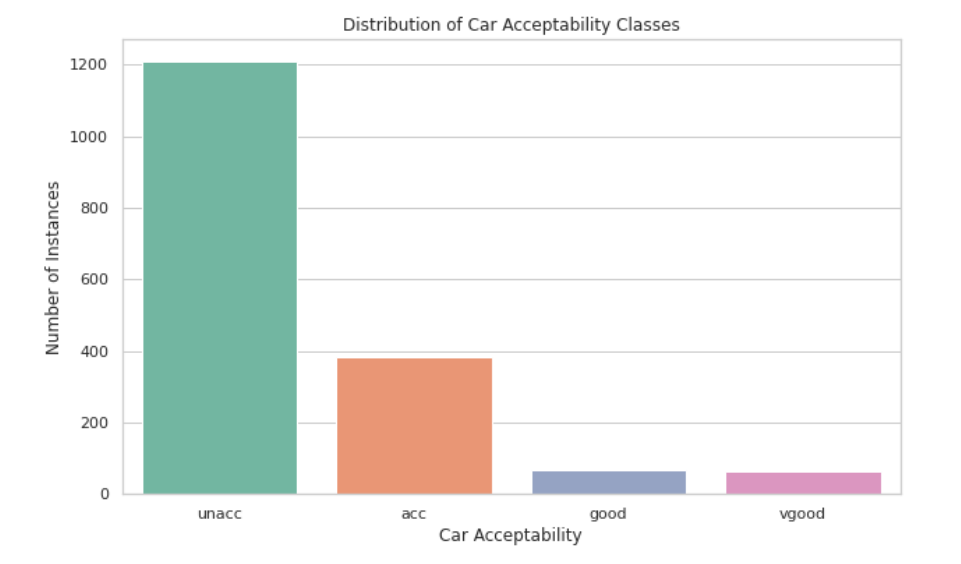

Zbiór danych jest niezrównoważony, przy czym klasa "unacc" (nieakceptowalna) ma znacznie więcej instancji niż inne klasy. Ten brak równowagi może wpłynąć na wydajność modelu, ponieważ może on być stronniczy w stosunku do klasy większościowej. Istotne jest, aby mieć to na uwadze podczas oceny modelu i rozważania potencjalnych technik rozwiązania problemu nierównowagi klas, takich jak ponowne próbkowanie lub użycie różnych metryk oceny.

### Gender

**Pełen opis oraz analiza zbioru została przedstawiona w dokumentacji wstępnej, jednak wyróżnie najważniejsze informacje o zbiorze pozwalające do poprawnego zinterpretowania wniosków oraz eksperymentów, które zostały opisane w sekcji poniżej.**

Zestaw danych Gender Classification na Kaggle jest zbiorem danych, który ma na celu przewidywanie płci osoby na podstawie pewnych atrybutów. Ten zestaw danych może być wykorzystany do trenowania modeli uczenia maszynowego do klasyfikacji płci i jest szczególnie przydatny do zrozumienia relacji między różnymi cechami i ich wpływu na przewidywanie płci.

Link: https://www.kaggle.com/datasets/elakiricoder/gender-classification-dataset

W zbiorze danych wyrózniamy atrybuty takie jak:

- long_hair - Ta kolumna zawiera 0 i 1, gdzie 1 oznacza "długie włosy", a 0 "nie długie włosy".
- forehead_width_cm - Ta kolumna jest w CM. Jest to szerokość czoła.
- forehead_height_cm - Jest to wysokość czoła i podana jest w Cm.
- nose_wide - Ta kolumna zawiera 0 i 1, gdzie 1 oznacza "szeroki nos", a 0 "nie szeroki nos".
- nose_long - Ta kolumna zawiera 0 i 1, gdzie 1 oznacza "długi nos", a 0 "nie długi nos".
- lips_thin - Ta kolumna zawiera 0 i 1, gdzie 1 reprezentuje "cienkie usta", a 0 to "Nie cienkie usta".
- distance_nose_to_lip_long - Ta kolumna zawiera 0 i 1, gdzie 1 oznacza "dużą odległość między nosem a ustami", podczas gdy 0 oznacza "małą odległość między nosem a ustami".

Naszą klasą jest przewidywanie płci:

- gender - "Male" albo "Female".



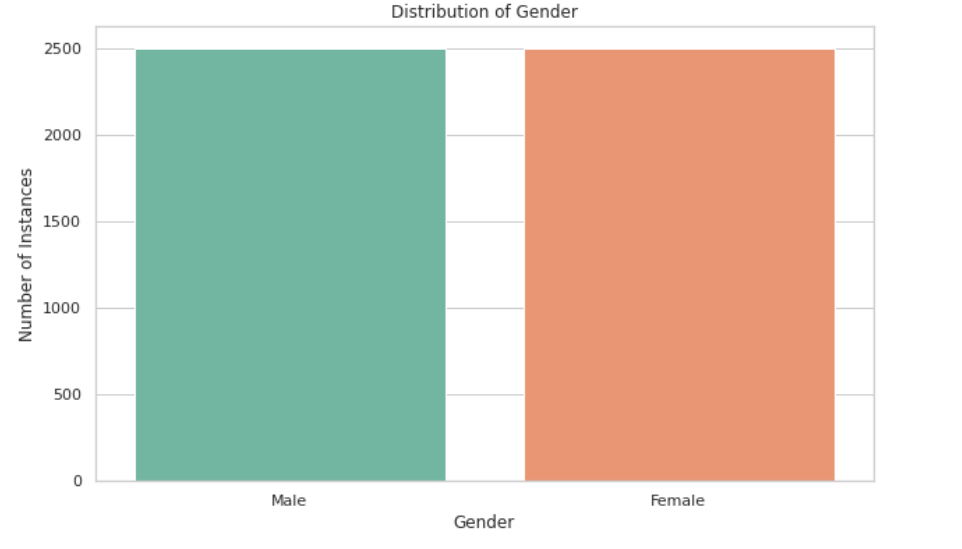

Na podstawie powyższego histogramu, widać że zbiór danych jest zbalansowany.

Zrównoważony zbiór danych zmniejsza bias w modelu, zapobiegając nadmiernemu wpływowi klasy większościowej. Innymi słowy, zapewnia, że model nie jest stronniczy w przewidywaniu klasy większościowej i ignorowaniu klasy mniejszościowej.

# Implementacja algorytmów wraz z opisem funkcjonalności

Szczegółowy opis użytych algorytmów **Random Forest, C45** oraz **ID3** został zawarty w dokumentacji wstępnej wraz z przykładami działania dla różnych zbiorów danych. Wraz zalgorytmami zostały szczegółowo opisane heurystyki takie jak entropia czy zysk informacyjny oraz sposób ich liczenia.

## Implementacja ID3

Poniżej znajduje się szczegółowy opis implementacji algorytmu ID3 oraz obliczeń entropii i zysku informacyjnego, które zrealizowałam.

Zaimplementowałam klasy `Node` i `Leaf` reprezentujące węzeł i liść w drzewie decyzyjnym. Węzeł przechowuje informację o cechach i swoich potomkach, którzy mogą być kolejnymi węzłami lub liśćmi. Liść przechowuje wartość, która jest przewidywaną etykietą dla danej ścieżki w drzewie.

Następnie zaimplementowałam główną klasę `ID3`, która implementuje algorytm drzewa decyzyjnego ID3. 

Poniżej opisuję, jakie funkcje pełnią poszczególne metody w tej klasie:

1. `__init__(self, max_depth, features_to_use: Optional[List[str]] = None, threads=None)`: Ta metoda jest konstruktorem klasy ID3, który inicjalizuje obiekt tej klasy. Parametry, które ta funkcja przyjmuje to:
    - `max_depth` (wymagane): Maksymalna głębokość drzewa. Jest to liczba, która określa, jak głęboko drzewo może być zbudowane. Głębokość drzewa to najdłuższa ścieżka od korzenia do liścia. Ustawienie zbyt dużej głębokości może prowadzić do przeuczenia modelu.
    - `features_to_use` (opcjonalne): Lista cech, które mają być używane do budowy drzewa. Jeżeli nie jest określone, używane są wszystkie cechy.
    - `threads` (opcjonalne): Liczba wątków do użycia podczas przewidywania. Jeżeli nie jest określone, używany jest jeden wątek.

2. `_information_gain(self, X: pd.DataFrame, Y: pd.Series, x: str) -> float`: Ta prywatna metoda oblicza i zwraca zysk informacyjny dla danej kolumny `x`. Zysk informacyjny jest miarą zmniejszenia entropii po podziale zbioru danych względem danej cechy. Parametry, które ta funkcja przyjmuje to:
    - `X` (wymagane): DataFrame zawierający cechy.
    - `Y` (wymagane): Series zawierający etykiety.
    - `x` (wymagane): Nazwa cechy, dla której obliczany jest zysk informacyjny.

3. `_max_information_gain(self, X: pd.DataFrame, Y: pd.Series) -> str`: Ta prywatna metoda oblicza zysk informacyjny dla wszystkich cech i zwraca nazwę cechy, która daje maksymalny zysk informacyjny. Parametry, które ta funkcja przyjmuje to:
    - `X` (wymagane): DataFrame zawierający cechy.
    - `Y` (wymagane): Series zawierający etykiety.

4. `_fit_algorithm(self, X: pd.DataFrame, Y: pd.Series, depth: int) -> Union[Node, Leaf]`: Ta prywatna metoda implementuje główny algorytm ID3. Parametry, które ta funkcja przyjmuje to:
    - `X` (wymagane): DataFrame zawierający cechy.
    - `Y` (wymagane): Series zawierający etykiety.
    - `depth` (wymagane): Aktualna głębokość drzewa.

5. `fit(self, X: pd.DataFrame, Y: pd.Series) -> None`: Ta metoda służy do dopasowania modelu do danych. Parametry, które ta funkcja przyjmuje to:
    - `X` (wymagane): DataFrame zawierający cechy. Wszystkie wartości powinny być już przetworzone i gotowe do użycia w modelu.
    - `Y` (wymagane): Series zawierający etykiety. Te etykiety są wartościami, które model będzie próbował przewidzieć.

6. `_predict_single(self, sample: Dict[str, Any]) -> str`: Ta prywatna metoda przewiduje etykietę dla pojedynczego przykładu. Parametry, które ta funkcja przyjmuje to:
    - `sample` (wymagane): Słownik reprezentujący pojedynczy przykład. Klucze to nazwy cech, a wartości to odpowiadające im wartości dla tego przykładu.

7. `predict(self, X: pd.DataFrame) -> Iterable[Any]`: Ta metoda przewiduje etykiety dla zbioru danych. Parametry, które ta funkcja przyjmuje to:
    - `X` (wymagane): DataFrame zawierający cechy. Wszystkie wartości powinny być już przetworzone i gotowe do użycia w modelu.

Podczas implementacji, metody `_information_gain` i `_max_information_gain` są wykorzystywane do określenia najważniejszych cech dla podziału danych, co jest kluczowym krokiem w budowaniu drzewa decyzyjnego. Wykorzystują one metrykę zwaną zyskiem informacyjnym, która mierzy redukcję niepewności (entropii) po podziale danych względem danej cechy. Najważniejsze cechy to te, które najbardziej redukują niepewność i zwiększają czystość podziałów.

Entropię oblicza się za pomocą wzoru:
```
H(Y) = - sum(p_i * log2(p_i))
```
gdzie `p_i` to prawdopodobieństwo wystąpienia i-tej klasy w zbiorze `Y`.

Zysk informacyjny oblicza się za pomocą wzoru:
```
IG(Y|X) = H(Y) - H(Y|X)
```
gdzie `H(Y)` to entropia zbioru `Y`, a `H(Y|X)` to średnia ważona entropii podzbiorów `Y` po podziale względem `X`.

Zysk informacyjny mierzy, jak dużo informacji zyskujemy o `Y` po podziale względem `X`. Im większy zysk informacyjny, tym lepiej cecha `X` rozdziela klasy w `Y`, a więc cecha `X` jest bardziej wartościowa dla modelu.



## Implementacja C45

Klasa `C45` jest główną klasą implementującą algorytm C4.5. Kiedy tworzymy instancję tej klasy, możemy zdefiniować parametry takie jak maksymalna głębokość drzewa (`max_depth`), cechy dyskretne (`discrete_features`), stosunek danych używanych do walidacji (`validation_ratio`) na którym jest użyty pruning, opcjonalne ziarno dla losowości (`random_seed`) oraz kryterium, które determinuje jak wybieramy najlepszy podział (`criterion`). Dostępne kryteria to `gain_ratio` i `inf_gain`.

Metoda `fit` jest używana do trenowania modelu na zestawie danych wejściowych X i etykietach Y. W trakcie trenowania, metoda dzieli dane na zestaw treningowy i walidacyjny, a następnie wywołuje funkcję `_fit_algorithm` do budowy drzewa decyzyjnego. Wreszcie, drzewo jest przycinane używając zestawu walidacyjnego.

Następnie, zaimplementowałam metodę `_fit_algorithm`, która wykonuje główną część procesu trenowania drzewa decyzyjnego. Funkcja `_fit_algorithm` jest funkcją rekurencyjną, która buduje drzewo decyzyjne. Na początku sprawdza, czy przekroczyła maksymalną głębokość, czy wszystkie etykiety są takie same, czy nie ma już cech do rozważenia. Jeśli którykolwiek z tych warunków jest spełniony, funkcja zwraca liść z najczęstszą klasą. W przeciwnym razie, szuka najlepszego podziału za pomocą metody `_best_split`. Jeżeli nie ma możliwych podziałów, zwraca liść. W przeciwnym razie, tworzy węzeł i rekurencyjnie wywołuje się na podzbiorach danych.

Metoda `_best_split` szuka najlepszego podziału dla danego zestawu danych. Dla każdej cechy, oblicza stosunek zysku (lub zysk informacyjny, w zależności od wybranego kryterium) dla wszystkich możliwych podziałów i zwraca podział z największym zyskiem.

Metoda `_predict_node` odpowiada za prognozowanie na podstawie konkretnego węzła. W zależności od typu węzła, różne podejście jest stosowane. Dla liści, zwracane są prognozy zgodnie z etykietą liścia. Dla węzła kategorycznego, metoda grupuje dane według wartości cechy i wykonuje predykcje dla każdej grupy. Dla węzła progowego, dane są dzielone na podstawie progu i dla każdej części są wykonywane predykcje.

Metoda `predict` pozwala na przewidywanie etykiet dla nowych danych wejściowych X. Wywołuje funkcję `_predict_node` na korzeniu drzewa, która rekurencyjnie przechodzi przez drzewo i zwraca przewidziane etykiety.

Funkcja `_error` oblicza błąd prognozy, porównując prawdziwe i prognozowane etykiety. Zwraca średnią wartość błędów.

Metoda `_prune` jest odpowiedzialna za przycinanie drzewa decyzyjnego. W zależności od typu węzła, różne podejście jest stosowane. W przypadku `CategoricalNode`, metoda przechodzi przez wszystkie dzieci i próbuje je przyciąć. Następnie, porównuje błąd przed i po przycięciu i decyduje, czy przyciąć drzewo na stałe. Analogicznie, dla `ThresholdNode`, metoda próbuje przyciąć lewe i prawe dzieci, a następnie porównuje błędy.

Klasa `C45` zawiera również trzy typy węzłów: `Leaf`, `CategoricalNode` i `ThresholdNode`. `Leaf` reprezentuje liść drzewa i przechowuje etykietę, która jest przewidywana, gdy instancja dociera do tego liścia. `CategoricalNode` jest węzłem, który dokonuje podziału na podstawie kategorycznej cechy, a `ThresholdNode` jest węzłem, który dokonuje podziału na podstawie cechy ciągłej. 

Zaimplementowana klasa `C45` zawiera także kilka metod służących do obliczania różnych metryk używanych podczas budowy drzewa decyzyjnego.

1. `entropy(y)`: Metoda ta oblicza entropię dla podanego zestawu etykiet `y`.

2. `information_gain(y, y1, y2)`: Metoda ta oblicza tzw. zysk informacyjny dla podziału zestawu etykiet `y` na dwa podzbiory `y1` i `y2`.

3. `gini_index(y)`: Metoda ta oblicza indeks Giniego dla podanego zestawu etykiet `y`. Indeks Giniego jest miarą zróżnicowania lub nierówności w zestawie danych; w kontekście drzewa decyzyjnego, może być używany jako alternatywa dla entropii do oceny jakości podziału.

4. `gini_gain(y, y1, y2)`: Metoda ta oblicza tzw. zysk Giniego dla podziału zestawu etykiet `y` na dwa podzbiory `y1` i `y2`. Zysk Giniego jest miarą tego, jak dużo "niezgody" (czyli zróżnicowania) usuwamy, dzieląc dane na podstawie pewnej cechy; w kontekście drzewa decyzyjnego, może być używany jako alternatywa dla zysku informacyjnego do decydowania, którą cechę użyć do podziału danych na danym etapie.

## Implementacja SklearnModel

Zaimplementowałam klasę `SklearnModel`, która służy jako opakowanie dla modeli dostarczonych przez bibliotekę scikit-learn. Głównym celem tej klasy jest konwersja danych tekstowych na dane numeryczne, które mogą być przetwarzane przez modele scikit-learn, a także konwersja wyników numerycznych z powrotem na dane tekstowe.

1. `__init__(self, model_class, discrete_feature_order: Dict[str, List[Any]], **kwargs)`: W konstruktorze tworzę instancję modelu scikit-learn, który zostanie użyty do trenowania i prognozowania. Inicjuję też słowniki, które będą służyły do mapowania wartości tekstowych na indeksy numeryczne i odwrotnie. Zmienna `discrete_feature_order` jest słownikiem, który pozwala określić preferowany porządek dla wartości poszczególnych cech dyskretnych.

2. `_sort_key(self, val, column)`: Zaimplementowałam tę prywatną funkcję, aby generować klucz służący do sortowania wartości cechy. Jeżeli dla danej kolumny nie określiłam porządku, zwracam niezmienioną wartość. W przeciwnym razie zwracam indeks wartości w zadanym porządku dla danej kolumny.

3. `fit(self, X: pd.DataFrame, Y: pd.Series)`: Ta metoda odpowiada za dopasowanie modelu do danych treningowych. Najpierw znajduję najczęściej występującą klasę w `Y` (która zostanie użyta później do obsługi nieznanych wartości cechy). Następnie tworzę mapowania dla wszystkich unikalnych wartości w każdej kolumnie `X` i `Y` (używając do tego metody `_sort_key`). Potem zastępuję wartości w `X` i `Y` odpowiadającymi im indeksami i dopasowuję model do tych przekształconych danych.

4. `predict(self, X: pd.DataFrame) -> Iterable[Any]`: Ta metoda służy do generowania predykcji na nowych danych. Najpierw zastępuję wartości w `X` odpowiadającymi im indeksami za pomocą mapowania `name2index`. Potem sprawdzam, czy są jakiekolwiek próbki, które zawierają wartość cechy, która nie pojawiła się podczas dopasowania (i zastępuję je najczęściej występującą klasą). Na końcu generuję predykcje modelu dla wszystkich próbek, które nie zawierają nieznanych wartości, i zwracam te predykcje jako wartości tekstowe.

Moja implementacja jest przykładem, jak można dostosować bibliotekę scikit-learn do obsługi danych tekstowych w sposób, który jest naturalny dla tego typu danych, jak i dla modeli, które normalnie wymagają danych numerycznych.


## Implemmmmmmmmmmmmmmmmmmmmmmmtacja zmodyfikowanego Random Forest'a

Zaimplementowałam klasę `RandomForest`, której głównym celem jest trenowanie i prognozowanie modelu lasu losowego - silnego modelu uczenia maszynowego, który tworzy ensemble (zbiór) drzew decyzyjnych.

1. W metodzie `__init__` zainicjowałam wszystkie parametry, które są potrzebne do stworzenia lasu losowego. Parametry te obejmują liczbę drzew w lesie (`n_estimators`), maksymalną liczbę cech, które mają być uwzględnione podczas tworzenia każdego drzewa (`max_features`), konstruktor drzewa (który pozwala na tworzenie różnych typów drzew, takich jak C45 lub ID3), a także różne parametry dotyczące próbkowania bootstrap (na przykład, czy zastępowanie jest dozwolone podczas próbkowania bootstrap i jaki procent próbek ma zostać wybrany).

2. Metoda `_generate_bootstrap_samples` jest używana do generowania próbek bootstrap, które są używane do trenowania każdego drzewa w lesie. Próbki bootstrap są generowane losowo z podmianą z oryginalnego zestawu danych, co pomaga wprowadzić różnorodność w model.

3. Zaimplementowałam również metodę `_get_max_features`, która decyduje, ile cech ma zostać uwzględnionych podczas tworzenia każdego drzewa w zależności od wartości `max_features`.

4. Metoda `_get_sample_probabilities` jest używana do obliczenia prawdopodobieństw dla każdej próbki w zestawie danych, które są następnie używane do generowania próbek bootstrap.

5. W metodzie `fit` trenuję las losowy. Dla każdego drzewa w lesie losowo wybieram cechy, generuję próbki bootstrap i dopasowuję drzewo do tych próbek. Kiedy drzewo jest trenowane, sprawdzam, jak dobrze prognozuje dla próbek, które nie były używane podczas jego trenowania (tzw. out-of-bag samples) i zapisuję te informacje do wykorzystania później.

6. Na końcu, w metodzie `predict`, prognozuję etykiety dla podanego zestawu próbek, korzystając z wszystkich drzew w lesie. Każde drzewo w lesie dokonuje swojej prognozy, a następnie wybieram najczęściej występującą prognozę z tych wszystkich prognoz jako ostateczną prognozę lasu losowego.

Zaimplementowałam więc pełne działanie modelu lasu losowego, począwszy od jego inicjalizacji, przez trenowanie poszczególnych drzew, aż po prognozowanie etykiet dla nowych próbek.

Jednak najbardziej efektywnym parametrem do realizacji projektu jest parametr `sampling_temperature`, dlatego zamierzam szczegółowo go opisać.

Parametr `sampling_temperature` jest używany w metodzie `_get_sample_probabilities` w celu regulacji prawdopodobieństwa wyboru konkretnych próbek podczas generowania zestawów bootstrap do trenowania drzew decyzyjnych. Metoda ta wykorzystuje błędy prognoz modelu na zestawie out-of-bag (OOB) do wyznaczenia tych prawdopodobieństw.

W szczególności, `sampling_temperature` jest używany do "temperowania" błędów, czyli do wpływania na rozkład prawdopodobieństwa próbek. Wartości błędów są podnoszone do potęgi równiej `sampling_temperature`, co wpływa na prawdopodobieństwo wyboru próbek podczas tworzenia nowych zestawów bootstrap.

Jeżeli `sampling_temperature` jest wysokie, wówczas różnice między prawdopodobieństwami poszczególnych próbek stają się bardziej wyraźne. To oznacza, że próbki, na których model popełnia większe błędy, są znacznie częściej wybierane do nowych zestawów bootstrap. W efekcie, tworzone drzewa decyzyjne są bardzie zróżnicowane, co może pomóc w poprawie generalizacji modelu.

Z drugiej strony, jeżeli `sampling_temperature` jest niskie, różnice między prawdopodobieństwami próbek są mniej wyraźne. Próbki, na których model popełnia większe błędy, są wówczas rzadziej wybierane do nowych zestawów bootstrap. Tworzone drzewa decyzyjne są wtedy mniej zróżnicowane. W szczególności `sampling_temperature=0` oznacza ze wszystkie próbki są wybierane z takim samym prawdopodobieństwiem, nie zależnie od błędów na zestawie OOB.

Dokładniej, jeśli $n_i$ jest liczbą wystąpień $i$-tej próbki w zbiorach OOB oraz $e_i$ jest liczbą pomyłek, to prawdopodobieństwo wyboru próbki jest proporcionalne do wagi $w_i = (\frac{e_i + 1}{n_i + 1})^{sampling\_temperature}$. W tym wzorze `sampling_temperature` jest użyte dla "wyostrzenia" prawdopodobieńst losowania. Taki podniesienie do potęgi jest potocznie zwane "temperature sampling" (np. uważywane w funckcji softmax z temperaturą). Addytant +1 w liczniku i mianowniku został dodany, sztucznie dodając błędną predykcje na początku. W ten sposób unikniemy zignorowania próbki w boostrapingu jeśli wszystkie drzewa dobrze skalsyfikowały tą próbke. Zamiast tego gdy wszystkie drzewa dobrze klasyfikują próbke, prawdopodobieństwo wybrania będzie maleć z liczbą drzew które miały go w zbiorze OOB.

Podsumowując, `sampling_temperature` jest parametrem, który pozwala regulować różnorodność tworzonych drzew decyzyjnych w modelu lasu losowego, a przez to również wpływać na zdolność modelu do generalizacji.

# Przedstawienie poprawności implementacji wraz z przeprowadzonymi testami

In [334]:
from functools import partial

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import sklearn.ensemble
import sklearn.linear_model
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from multiprocessing import Pool

from algorithms.C45 import C45
from algorithms.ID3 import ID3
from algorithms.RandomForest import RandomForest
from algorithms.SklearnModel import SklearnModel
from utils import load_gender_dataset, load_car_dataset
import warnings
from typing import Tuple, Dict, List, Callable, Any, Iterable
warnings.filterwarnings('ignore')

In [235]:
def load_dataset(dataset_name: str):
    if dataset_name == 'gender':
        df, cols = load_gender_dataset()
    elif dataset_name == 'car':
        df, cols = load_car_dataset()
    else:
        raise ValueError("Invalid dataset name. Choose either 'gender' or 'car'.")
    return df, cols

Poniżej zaimplementowałam pętlę, która przeprowadza eksperyment na dwóch zestawach danych: 'gender' i 'car'. Dla każdego zestawu danych, wczytuję dane do dataframe'u pandas, a następnie dzielę dane na zestawy cech (X) i targetów (Y).

Załadowałam sześć klasyfikatorów do listy 'classifiers', w tym trzy różne implementacje drzew decyzyjnych (ID3, C45, SklearnDecisionTree) oraz trzy różne implementacje lasów losowych (RandomForestID3, RandomForestC45, SklearnRandomForest). Każdy z tych klasyfikatorów jest inicjalizowany z konkretnymi parametrami, które są identyczne w konkretnych klasyfikatorach.

Nastepnie stworzyłam pustą listę 'accuracies', która zostanie wypełniona dokładnościami dla każdego z klasyfikatorów. Następnie skonfigurowałam walidację krzyżową z 5 podziałami.

W pętli, dla każdego klasyfikatora, trenuję model na danych treningowych i obliczam jego dokładność na danych walidacyjnych (walidacja krzyżowa). Dokładności dla każdego klasyfikatora są zapisywane w liście 'accuracies'.

Na koniec, dla każdego klasyfikatora, wyświetlam średnią dokładność oraz odchylenie standardowe dokładności uzyskanej na walidacji. Pozwala mi to na ocenę, który z klasyfikatorów radzi sobie najlepiej na danych testowych, biorąc pod uwagę zarówno średnią dokładność, jak i jej stabilność (odchylenie standardowe).

In [339]:
for dataset in ['gender', 'car']:
    print('DATASET:', dataset)
    df, discrete_columns = load_dataset(dataset)

    X, Y = df.drop(columns=['target']), df['target']

    classifiers = [
        ('ID3', ID3(max_depth=100, features_to_use=list(set(discrete_columns.keys())))),
        ('C45',
         C45(max_depth=100, discrete_features=list(discrete_columns.keys()), validation_ratio=0.0, random_seed=42)),
        ('SklearnDecisionTree',
         SklearnModel(DecisionTreeClassifier, max_depth=100, discrete_feature_order=discrete_columns)),
        ('RandomForestID3', RandomForest(
            n_estimators=20, max_features=6, bootstrap_fraction=1, sampling_temperature=0,
            tree_constructor=partial(ID3, max_depth=100, features_to_use=list(set(discrete_columns.keys()))))),
        ('RandomForestC45', RandomForest(
            n_estimators=20, max_features=6, bootstrap_fraction=1, sampling_temperature=0,
            tree_constructor=partial(C45, max_depth=100, discrete_features=list(discrete_columns.keys()), validation_ratio=0.0, random_seed=42))),
        ('SklearnRandomForest', SklearnModel(sklearn.ensemble.RandomForestClassifier, discrete_feature_order=discrete_columns,
            n_estimators=20, max_features=6)),
    ]

    accuracies = []

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    for name, clf in classifiers:
        accuracies.append([])
        for train_idx, val_idx in skf.split(X, Y):
            clf.fit(X.iloc[train_idx], Y.iloc[train_idx])
            Y_pred = clf.predict(X.iloc[val_idx])
            accuracy = accuracy_score(Y.iloc[val_idx], Y_pred)
            accuracies[-1].append(accuracy)
        print(f"{name} Accuracy: {np.mean(accuracies[-1]):.4f} +/- {np.std(accuracies[-1]):.4f}")    
        
    print()

DATASET: gender
ID3 Accuracy: 0.9580 +/- 0.0035
C45 Accuracy: 0.9654 +/- 0.0055
SklearnDecisionTree Accuracy: 0.9648 +/- 0.0052
RandomForestID3 Accuracy: 0.9578 +/- 0.0033
RandomForestC45 Accuracy: 0.9677 +/- 0.0037
SklearnRandomForest Accuracy: 0.9688 +/- 0.0048

DATASET: car
ID3 Accuracy: 0.8976 +/- 0.0103
C45 Accuracy: 0.9346 +/- 0.0141
SklearnDecisionTree Accuracy: 0.9774 +/- 0.0067
RandomForestID3 Accuracy: 0.8976 +/- 0.0103
RandomForestC45 Accuracy: 0.9335 +/- 0.0136
SklearnRandomForest Accuracy: 0.9792 +/- 0.0065




**Wnioski**

Na podstawie uzyskanych wyników, możemy zauważyć, że dla obu zestawów danych, algorytmy oparte na lasach losowych (Random Forest) generalnie osiągają lepsze wyniki niż pojedyncze drzewa decyzyjne. Jest to dość typowe, ponieważ lasy losowe są znane ze swojej zdolności do redukcji overfittingu, co prowadzi do lepszej generalizacji na nowych danych.

Na zbiorze danych "gender", algorytm `RandomForestC45`, który jest moją własnoręczną implementacją, osiągnął dokładność porównywalną z algorytmem `SklearnRandomForest`, co sugeruje, że moja implementacja algorytmu jest poprawna. Na zbiorze danych "car", algorytm SklearnRandomForest osiągnął nieco lepsze wyniki, ale różnica nie jest znacząca, biorąc pod uwagę odchylenie standardowe, które w mojej zaimplementowanej klasie jest nieco mniejsze.

Co do implementacji algorytmu `C45`, wyniki sugerują, że jest ona poprawna. Algorytm C45 osiągnął wyższą dokładność niż ID3 dla obu zestawów danych, co jest spodziewane, biorąc pod uwagę, że C45 jest ulepszoną wersją algorytmu ID3 z dodatkowymi funkcjami, takimi jak obsługa cech ciągłych i brakujących danych. Wyniki algorytmu C45 są również porównywalne z wynikami algorytmu SklearnDecisionTree, co dodatkowo potwierdza poprawność mojej implementacji (jednakowe accuracy oraz odchylenie).

Ogólnie rzecz biorąc, wyniki te pokazują, że moja implementacja algorytmów drzew decyzyjnych i lasów losowych działa skutecznie i jest porównywalna z bibliotecznymi implementacjami sklearn. Wszakże, dla bardziej skomplikowanych zestawów danych, mogą być potrzebne dalsze testy i dostosowania.

Celowo ustawiłam brak zbioru do pruningu (`validation_ratio=0`) dla C4.5, żeby być porównywalnym do drzewa decyzyjnego z biblioteki scikit-learn (ono go nie używa domyślnie). Efekt tego parametru będzie pokazany później w eksperymentach.
Warto zaznaczyć, że zbiory danych, na których pracowałam, były dość małe, co mogło wpłynąć na efektywność niektórych funkcji w mojej implementacji algorytmu C45, takich jak przycinanie (pruning). Małe zbiory danych mogą nie zawierać wystarczającej ilości szumów, które mogłyby skutkować overfittingiem, a tym samym przycinanie może nie przynosić znaczącej poprawy wyników.

Wyniki mojej implementacji algorytmu C45 wskazują na skuteczność algorytmu, ale warto zauważyć, że efekty przycinania mogłyby być bardziej widoczne, gdyby zbiory danych były większe. Aby w pełni ocenić skuteczność przycinania w moim algorytmie C45, idealnym byłoby przeprowadzenie dalszych testów na większych i bardziej złożonych zbiorach danych, które już mogą być trudniej dostepne niż te które zaimportowałam z dostępnych ogólnodostępnych zródeł.

# Szukanie najlepszych hiperparametrów

Zaimplementowałam dwie funkcje: `evaluate_model` i `plot_factor_dependency`, które służą do oceny i analizy modeli klasyfikacyjnych.

Funkcję `evaluate_model` stworzyłam w celu oceny wybranego modelu poprzez wykorzystanie metody walidacji krzyżowej oraz obliczenie dokładności. W tym celu, funkcja przyjmuje dane wejściowe `X` (dane cech) i `Y` (dane docelowe), wywołanie tworzące model (`model_constructor`), argumenty przekazywane do konstruktora modelu (`model_args`), liczbę podziałów danych do kroswalidacji (`n_splits`, domyślnie ustawioną na 5) oraz flagę pozwalającą na włączenie lub wyłączenie dodatkowego wyjścia (`verbose`, domyślnie ustawioną na True). W rezultacie funkcja zwraca dokładność modelu.

Funkcję `plot_factor_dependency` zaprojektowałam z myślą o generowaniu wykresów pokazujących zależność dokładności modelu od konkretnego parametru. Funkcja przyjmuje dane wejściowe `X` i `Y`, wywołanie tworzące model (`model_constructor`), nazwę czynnika do badania (`name`), wartości czynnika do przetestowania (`values`), domyślne argumenty przekazywane do konstruktora modelu (`default_args`), liczbę powtórzeń oceny dla każdej wartości czynnika (`reps`, domyślnie ustawioną na 5), flagę określającą, czy na osi x ma być skala logarytmiczna (`xlog`, domyślnie False), opcjonalny pulę obliczeniową do równoległego wykonania ewaluacji (`pool`, domyślnie ustawioną na wbudowane funkcje Pythona) oraz flagę określającą, czy wykres ma być natychmiast wyświetlony (`show`, domyślnie True). Na podstawie przekazanych argumentów, funkcja generuje wykres zależności dokładności modelu od wartości danego czynnika, co umożliwia analizę wpływu danego parametru na dokładność modelu.

In [366]:
def evaluate_model(X, Y, model_constructor, model_args, n_splits=5, verbose=True):
    """
    Evaluates the model using cross-validation and calculates accuracy.

    Parameters
    ----------
    X : DataFrame
        Features data.
    Y : Series
        Target data.
    model_constructor : callable
        Constructor for the model.
    model_args : dict
        Arguments for the model constructor.
    n_splits : int, optional
        The number of folds in the cross-validation, by default 5.
    verbose : bool, optional
        Whether to display extra output or not, by default True.

    Returns
    -------
    float
        Accuracy of the model.
    """
    preds = []
    gt = []
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=model_args['random_seed'])
    for i, (train_indices, val_indices) in enumerate(skf.split(X, Y)):
        model = model_constructor(**model_args)
        model.fit(X.iloc[train_indices], Y.iloc[train_indices])
        preds.append(model.predict(X.iloc[val_indices]))
        gt.append(Y.iloc[val_indices])

    preds = np.concatenate(preds)
    gt = np.concatenate(gt)
    if verbose:
        ConfusionMatrixDisplay.from_predictions(gt, preds, normalize="true")
    return (preds == gt).mean()

In [270]:
def plot_factor_dependency(X, Y, model_constructor, name, values, default_args, reps=5, xlog=False, pool=__builtins__, show=True, evaluate_model=evaluate_model):
    """
    Plots the dependency of the model's accuracy on a specific factor.

    Parameters
    ----------
    X : DataFrame
        Features data.
    Y : Series
        Target data.
    model_constructor : callable
        Constructor for the model.
    name : str
        The name of the factor to vary.
    values : list
        The values of the factor to try.
    default_args : dict
        Default arguments to pass to the model constructor.
    reps : int, optional
        Number of times to repeat the evaluation for each factor value, by default 5.
    xlog : bool, optional
        Whether to use a logarithmic scale for the x-axis, by default False.
    pool : Pool, optional
        An optional multiprocessing pool to parallelize the evaluation, by default Python's built-in functions.
    show : bool, optional
        Whether to display the plot immediately or not, by default True.
    """
    res = {name: [], 'accuracy': []}
    for arg in values:
        args = default_args.copy()
        args[name] = arg
        
        for accuracy in pool.map(partial(evaluate_model, X, Y, model_constructor, verbose=False), [args | {'random_seed': i} for i in range(reps)]):
            res[name].append(arg)
            res['accuracy'].append(accuracy)

    
    df = pd.DataFrame.from_dict(res)
    plot_df = df.copy()
    if not all([isinstance(v, float) and not isinstance(v, int) for v in plot_df[name]]):
        plot_df[name] = plot_df[name].astype(str)
    sns.lineplot(data=plot_df, x=name, y='accuracy', errorbar='sd')
    sns.scatterplot(data=plot_df, x=name, y='accuracy', alpha=0.05)
    if xlog:
        plt.xscale('log')
    
    #Rysowanie poziomej najlepszej linnii
    aggregated_df = plot_df.groupby(name).mean().reset_index()
    row = aggregated_df[aggregated_df.accuracy == aggregated_df.accuracy.max()]
    value, acc = row[name].iloc[0], row['accuracy'].iloc[0]
    plt.axvline(value, linestyle='dashed', color='r')
    plt.title(f'{name}\nfound best {name}={value} with average accuracy {acc * 100:.2f}%')
    if show:
        plt.show()
        
    aggregated_df = df.groupby(name).mean().reset_index()
    row = aggregated_df[aggregated_df.accuracy == aggregated_df.accuracy.max()]
    value, acc = row[name].iloc[0], row['accuracy'].iloc[0]
    if str(type(value)).startswith("<class 'numpy."):
        value = value.item()
    best_args = default_args.copy()
    best_args[name] = value
    return best_args

In [11]:
def id3_constructor(random_seed, **kwargs): 
    return ID3(features_to_use=list(columns.keys()), **kwargs)

def c45_constructor(**kwargs):
    return C45(discrete_features=list(columns.keys()), **kwargs)

def sklearn_constructor(random_seed, **kwargs):
    return SklearnModel(model_class=DecisionTreeClassifier, discrete_feature_order=columns, **kwargs)

def tree_constructor(kind, **kwargs):
    if kind == 'id3':
        return id3_constructor(**kwargs)
    elif kind == 'c45':
        return c45_constructor(**kwargs)
    elif kind == 'sklearn':
        return sklearn_constructor(**kwargs)
    else:
        assert 0
        
def rf_constructor(tree_kwargs, random_seed, **kwargs):
    return RandomForest(**kwargs, random_seed=random_seed, tree_constructor=lambda: tree_constructor(**tree_kwargs, random_seed=random_seed))

W powyższym kodzie, zaimplementowałam następujące funkcje:

1. `id3_constructor(random_seed, **kwargs)` - Jest to konstruktor dla algorytmu drzewa decyzyjnego ID3. Pozwala on na przekazanie różnych argumentów do algorytmu (dzięki wykorzystaniu `**kwargs`). Parametr `random_seed` służy do losowości podzialu zbioru w walidacji krzyżowej, oraz jest ignorowany w ID3, jako że budowanie drzewa ID3 jest deterministyczne.

2. `c45_constructor(**kwargs)` - Podobnie jak wyżej, jest to konstruktor dla algorytmu C4.5. Również pozwala na przekazanie różnych argumentów do algorytmu za pomocą `**kwargs`.

3. `tree_constructor(kind, **kwargs)` - Ta funkcja to wyższy poziom abstrakcji, który pozwala na wybór między konstruktorem ID3, C4.5, a sklearn w zależności od przekazanego argumentu `kind`.

4. `rf_constructor(tree_kwargs, random_seed, **kwargs)` - Jest to konstruktor dla algorytmu Random Forest. Pozwala na przekazanie argumentów do konstruktora drzewa (`tree_kwargs`), ustawienie ziarna losowości (`random_seed`) oraz na przekazanie dodatkowych argumentów do algorytmu Random Forest za pomocą `**kwargs`. Co ciekawe, tworzy on funkcję `lambda`, która zwraca konstruktor drzewa, pozwalając na dynamiczne tworzenie drzew w algorytmie Random Forest.

5. `sklearn_constructor` - Jest to konstruktor dla algorytmu drzewa decyzyjnego zimportowanego z biblioteki Scikit-learn. Pozwala on na przekazanie różnych argumentów do algorytmu (dzięki wykorzystaniu `**kwargs`).

Założenie każdej funkcji jest takie że może przyjmować argument `random_seed` (albo explicite albo w `**kwargs`), do ustalenia ziarna losowości i podziału walidacji krzyżowej.

## Niezbalansowany zbiór danych -- Car 

In [344]:
df, columns = load_dataset('car')
X, Y = df.drop(columns='target'), df['target']

In [226]:
X, Y, columns

(     buying  maint  doors persons lug_boot safety
 0     vhigh  vhigh      2       2    small    low
 1     vhigh  vhigh      2       2    small    med
 2     vhigh  vhigh      2       2    small   high
 3     vhigh  vhigh      2       2      med    low
 4     vhigh  vhigh      2       2      med    med
 ...     ...    ...    ...     ...      ...    ...
 1723    low    low  5more    more      med    med
 1724    low    low  5more    more      med   high
 1725    low    low  5more    more      big    low
 1726    low    low  5more    more      big    med
 1727    low    low  5more    more      big   high
 
 [1728 rows x 6 columns],
 0       unacc
 1       unacc
 2       unacc
 3       unacc
 4       unacc
         ...  
 1723     good
 1724    vgood
 1725    unacc
 1726     good
 1727    vgood
 Name: target, Length: 1728, dtype: object,
 {'buying': ['low', 'med', 'high', 'vhigh'],
  'maint': ['low', 'med', 'high', 'vhigh'],
  'doors': ['2', '3', '4', '5more'],
  'persons': ['2', '4', '

Dla powyższego zbioru mamy 6 atrybutów dyskretnych/kategorycznych, dla których zostaną przeprowadzone eskperymenty. Zgodnie z poprzednią dokumentacja zbiór jest niezbalansowany, gdzie klasą większościową jest `unacc`.

### Maximum Depth

Maksymalna głębokość drzewa jest istotnym parametrem w algorytmach drzew decyzyjnych, takich jak ID3. Wpływa on na złożoność modelu - mniejsza głębokość może prowadzić do niedopasowania (ang. underfitting), gdy model jest zbyt prosty, aby nauczyć się struktury danych, natomiast większa głębokość może prowadzić do przetrenowania (ang. overfitting), gdy model jest zbyt skomplikowany i "nauczy się na pamięć" danych treningowych, co będzie skutkowało słabym działaniem na nowych, niewidzianych danych.

Obliczenia zostały przyspieszone za pomocą współbieżności, gdzie każda iteracja walidacji krzyżowej była przeprowadzana równolegle (24 repetycji eksperymentu, tzn. 24 walidacje krzyżowe z różnymi random seed'ami)

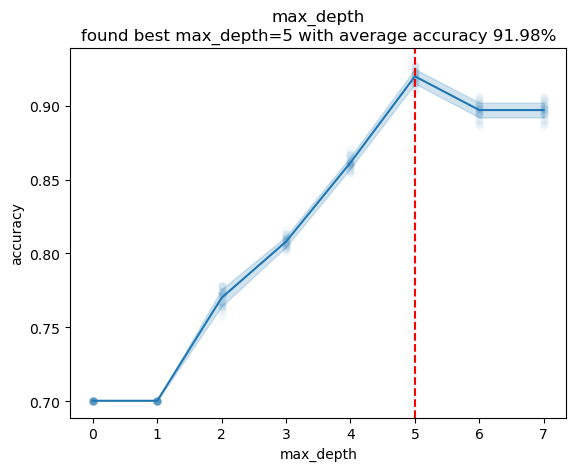

In [20]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, id3_constructor, 'max_depth', range(8), {}, reps=24, pool=pool)

Dla algorytmu ID3 najlepszą wartością dla maksymalnej głębokości drzewa decyzyjnego (max_depth) jest 5. Ustalanie tego parametru na wartość 5 pozwala osiągnąć średnią dokładność klasyfikacji na poziomie 91.98%. Spadek z wartości 5 na 6 dla `max_depth`, spowodowany tym że ID3 zwraca najczęstszą powatzająca się klase, jeśli nie ma atrybutu w tym podziale (dla pewności próbowałam zmienić implementacje algorytmu żeby wybierał najczęstszą klasę z liści podrzewa na którym atrybut nie został znaleziony (tzn. tak jak w C4.5) i wynik dla głębokości 6 nie malał).

Wynik dla głebokości 6 i 7 (i każdej następnej) jest taki sam, jako ze w zbiorze danych mamy tylko 6 atrybutów więc 6 jest maksymalną głębokością drzewa.

Cały proces jest przyspieszany poprzez wykorzystanie wielowątkowości (dokładniej, wieloprocesowości) - stąd użycie Pool z pakietu multiprocessing. Wszystkie procesy są uruchamiane równolegle na 24 rdzeniach.

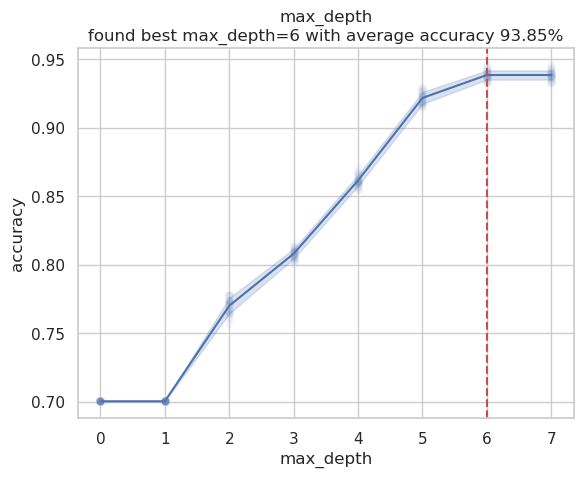

In [346]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, c45_constructor, 'max_depth', [0 , 1, 2, 3, 4, 5, 6, 7], {'validation_ratio': 0, 'criterion': 'inf_gain'}, reps=24, pool=pool)

W celu dodatkowego sprawdzenia poprawności implementacji, zaimplementowałam i wykonałam C4.5 z kryterium podziału zysku informacji. W tym zbiorze danych mamy tylko zmienne kategoryczne, więc ID3 oraz C4.5 z kryterium podziału zysku informacji są równoważne, z dokładnością do predykcji w sytuacji gdy jakaś wartość nie zostanie znaleziona (ID3 zwaraca najczęstszą klase w całym zbiorze treningowym, a C4.5 sprawdza wszystkie podrzewa). Jak widac wykresy dla ID3 i C4.5 są prawie identyczne, oprócz głębokości 6 dla której jak pisałam wcześniej ID3 i C4.5 ma inny mechanizm predykcji próbek dla których atrybut nie został znaleziony.

Tak samo jak dla ID3, maksymalna głębokość drzewa to 6, więc wszystkie drzewa dla głębokości >=6 są takie identyczne.

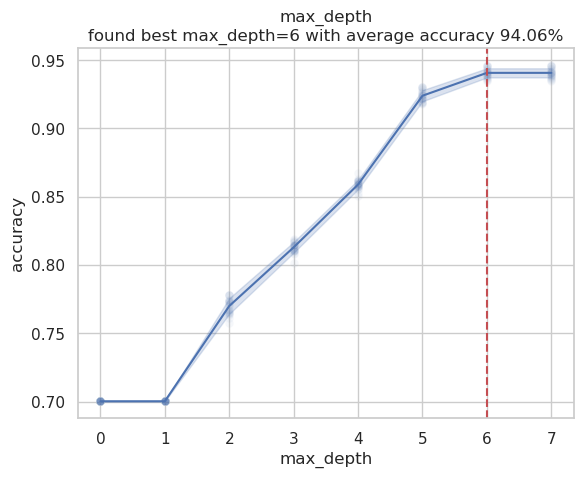

In [345]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, c45_constructor, 'max_depth', [0, 1, 2, 3, 4, 5, 6, 7], {'validation_ratio': 0}, reps=24, pool=pool)

W przypadku używania algorytmu C4.5, maksymalna głębokość drzewa decyzyjnego (max_depth), która daje najwyższą średnią dokładność klasyfikacji, wynosi 6, a dokładność modelu wynosi 94.06%. Zastosowanie C4.5 z tym parametrem umożliwiło uzyskanie lepszej precyzji niż algorytm ID3 z maksymalną głębokością drzewa równą 5 oraz nie znacznie lepiej niż C4.5 z kryterium podziału zysku informacji. Można z tego wywnioskować, że algorytm C4.5 jest w stanie lepiej modelować strukturę danego zestawu danych i jest bardziej odporny na przetrenowanie (overfitting). Ustawienie parametru `validation-ratio` na wartość 0 oznacza, że w drzewie C45 nie występuje "pruning", drzewo strukturą podobne jest do drzewa zimportowanego z biblioteki Scikit-Learn, co pokaże w poniższym doświadczeniu.

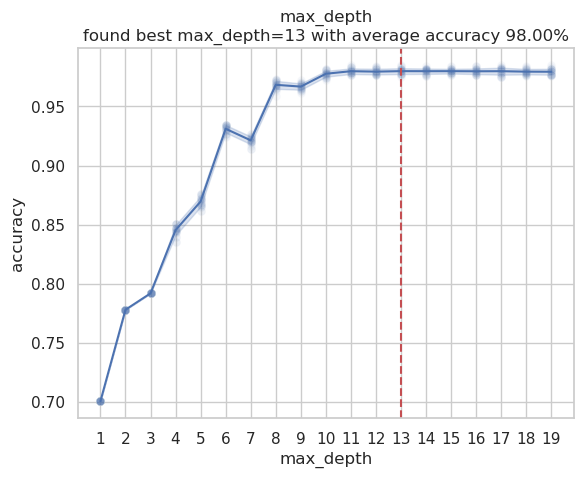

In [350]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, sklearn_constructor, 'max_depth', range(1, 20), {}, reps=24, pool=pool)

W odniesieniu do klasyfikatora z pakietu Scikit-Learn, najlepszym parametrem max_depth jest >=11, co daje dokładność klasyfikacji na poziomie 98%. Jest to bardziej dokładne niż wyniki dla C4.5 oraz ID3. Jest to spowodowane tym, że takie drzewo jest znacznie inne oraz ma "więcej informacji", tzn. traktuje ono atrybuty jako ciągłe (uporządkowane ręcznie, jako ze ma to sens dla tego zbioru danych, np. liczba drzwi samochodu która może być "2", "3", "4", lub "5+"). Dlatego też może mieć takie drzewo więcej podziałów niż atrybutów, tzn. nie które atrybuty mogą wystąpić kilka razy z innym threshold'em.

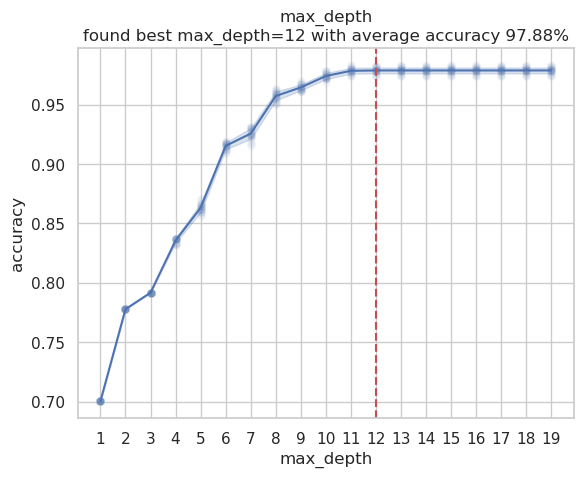

In [356]:
def c45_constructor_continuous(**kwargs):
    return SklearnModel(model_class=partial(C45, discrete_features=[]), discrete_feature_order=columns, **kwargs)
with Pool(24) as pool:
    plot_factor_dependency(X, Y, c45_constructor_continuous, 'max_depth', range(1, 20), {'validation_ratio': 0}, reps=24, pool=pool)

Jeśli odpalimy algorytm C4.5, traktując zmienne jako ciągłe (tak samo jak w przypadku drzewa z scikit-learna), otrzymujemy taki sam wynik.

W reszcie tej sekcji będziemy stosować C4.5 na zmiennych kategorycznych żeby zaprezentować wpływ parametrów na ten zbiór danych bez dodatkowych założeń na temat kolejności wartości poszczególnych parameterów. Będzie to przetestowane na "głównym" hiperparametrze projektu dotyczącym częstości próbkowania błędnie klasyfikowanych próbek w lesie losowym (`sampling_temperature`).

### Validation Ratio

Parametr `validation_ratio` jest używany do określenia proporcji danych używanych do tworzenia drzewa, które są następnie wykorzystywane do przycinania drzewa. Głównym celem przycinania jest zapobieganie przetrenowaniu (overfitting) modelu, co zwykle występuje, gdy model jest zbyt złożony i "nauczył się na pamięć" danych treningowych. Przycinanie pomaga zredukować złożoność modelu i poprawić jego zdolność do generalizacji na nowych danych.

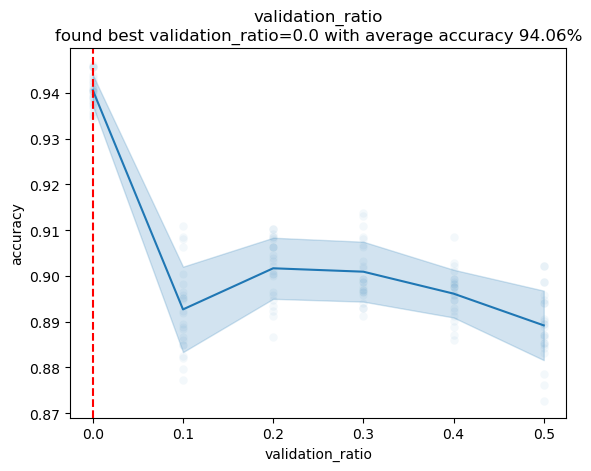

In [23]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, c45_constructor, 'validation_ratio', np.linspace(0, 0.5, 6), {'max_depth': 6}, reps=24, pool=pool)

Zgodnie z wynikami analizy najlepsza wartość validation_ratio dla algorytmu C4.5 wynosi 0, oznacza to, że algorytm działał najlepiej bez przycinania drzewa. 

Może to wynikać z następujących przyczyn:

1. Zestaw danych może być rzeczywiście zbyt mały, aby korzyści z przycinania stały się widoczne. Przycinanie jest najbardziej skuteczne, gdy mamy do czynienia z dużymi, skomplikowanymi drzewami, które są podatne na przetrenowanie. Jeżeli zestaw danych jest niewielki, model może nie być wystarczająco złożony, aby przetrenowanie było problemem.

2. Możliwe, że algorytm C4.5 już skutecznie radzi sobie z przetrenowaniem przez swoje podstawowe strategie tworzenia drzewa, a dodatkowe przycinanie nie jest potrzebne.

3. Struktura danych może być taka, że nawet pełne drzewo decyzyjne nie prowadzi do przetrenowania. Inaczej mówiąc, dane mogą być na tyle "proste", że pełne drzewo nie przekomplikowuje modelu.

Interesujące jest to że dla niezerowego zbioru pruningowego widać zależność bitoniczną (tzn. pierwsze rośnie a potem maleje). Ma to sens jako że za mało danych do pruningu będzie skutkowało w błędnym pruningu, oraz za dużo danych do pruningu będzie sktokowało w małej liczbie danych przeznaczonych do treningu.

### Max Features

Parametr `max_features` w modelu lasów losowych określa liczbę cech, które są brane pod uwagę przy wyborze najlepszego podziału w każdym węźle drzewa.

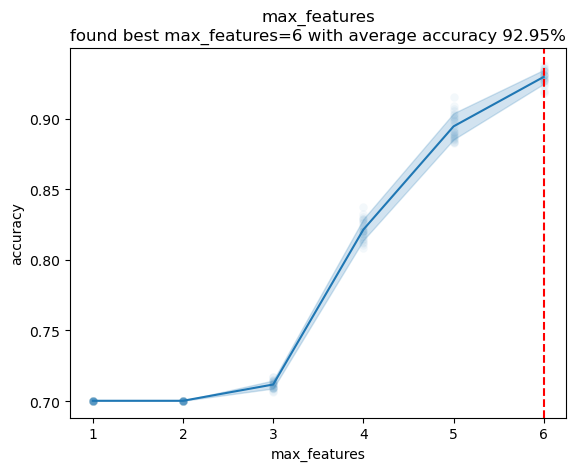

In [42]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, rf_constructor, 'max_features', range(1,7),
                           {'n_estimators': 80, 'bootstrap_fraction': 1, 'sampling_temperature': 0, 'tree_kwargs': {'kind': 'id3', 'max_depth': 5}},
                           reps=24, pool=pool)

W przypadku wykorzystania algorytmu ID3 w modelu lasu losowego, najlepszą wartością `max_features` okazało się 6, co odpowiada wszystkim cechom w danych (ponieważ zestaw danych ma 6 cech). Oznacza to, że model działał najlepiej, gdy każdy węzeł drzewa mógł rozważać wszystkie cechy podczas decydowania o podziale. Dokładność klasyfikacji wyniosła 92.95%.

`sampling_temperature=0` oznacza że wszystkie próbki do boostrapingu traktujemy jako tak samo prawdopodobne.

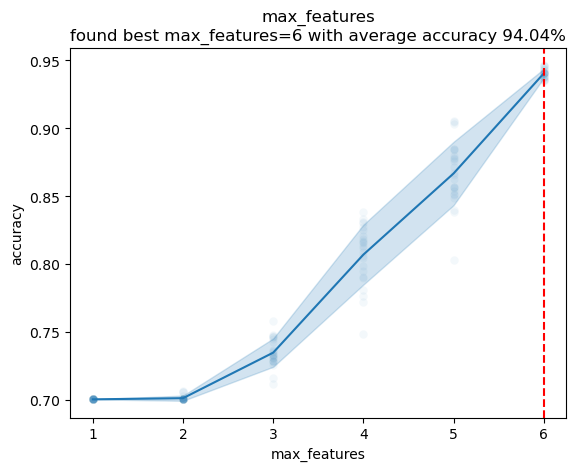

CPU times: user 359 ms, sys: 209 ms, total: 568 ms
Wall time: 2min 4s


In [44]:
%%time
with Pool(24) as pool:
    plot_factor_dependency(X, Y, rf_constructor, 'max_features', range(1,7),
                           {'n_estimators': 10, 'bootstrap_fraction': 1, 'sampling_temperature': 0, 'tree_kwargs': {'kind': 'c45', 'max_depth': 6, 'validation_ratio': 0}},
                           reps=24, pool=pool)

Podobnie, dla algorytmu C4.5 w modelu lasu losowego, najlepszą wartością `max_features` była również 6, co znowu odpowiada wszystkim cechom. Dokładność klasyfikacji wyniosła w tym przypadku 94.04%, co jest nieznacznie lepsze niż dla algorytmu ID3.

Podsumowując, zarówno dla algorytmu ID3, jak i C4.5, modele lasów losowych działały najlepiej, gdy każdy węzeł drzewa mógł rozważać wszystkie dostępne cechy podczas decydowania o podziale. To może sugerować, że wszystkie cechy w danych są istotne dla predykcji i że ograniczanie liczby rozważanych cech prowadzi do gorszej wydajności. Wszakże, ta zależność może się różnić dla różnych zestawów danych, dlatego zawsze warto przeprowadzić taką analizę dla danego problemu lub zestawu danych.

### Number of estimators

Parametr `n_estimators` w modelu lasów losowych określa liczbę drzew, które mają być utworzone w modelu. Jest to jeden z najważniejszych parametrów do dostrajania, ponieważ wpływa on bezpośrednio na wydajność modelu.

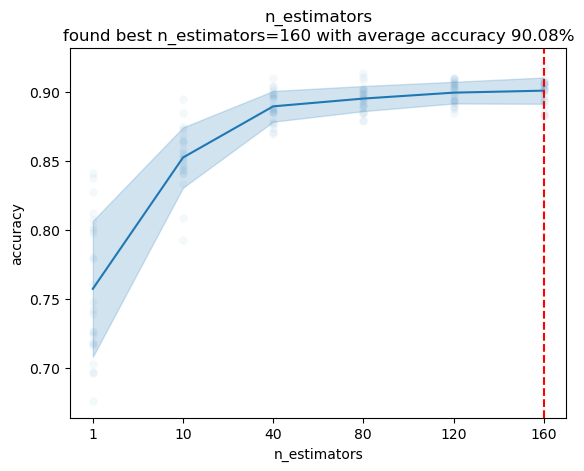

In [41]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, rf_constructor, 'n_estimators', [1, 10, 40, 80, 120, 160],
                           {'max_features': 5, 'bootstrap_fraction': 1, 'sampling_temperature': 0, 'tree_kwargs': {'kind': 'id3', 'max_depth': 5}},
                           reps=24, pool=pool)

Dla algorytmu ID3 maksymalna dokładność (90.08%) została osiągnięta dla `n_estimators` równego 160. To sugeruje, że dla tego konkretnego modelu i zestawu danych, większa liczba drzew prowadzi do lepszej wydajności. Na wykresie obserwujemy również znaczne odchylenie co może wnioskować, że wybór estymatorów od wartości większej od 80 może nie mieć, aż tak dużego znaczenia.

Generalnie dla lasów losowych, więkrza liczba drzew **zawsze** powinna ulepszyć predykcje (z asymptotą w pewnej wartości granicznej), w przypadku standardowego lasu losowego ze standardowym boostrapingiem.

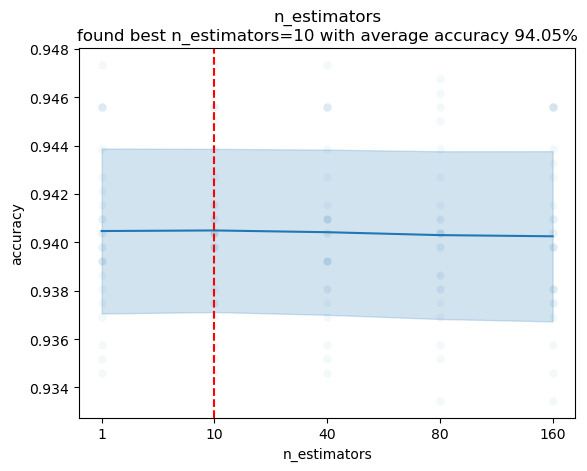

CPU times: user 407 ms, sys: 253 ms, total: 659 ms
Wall time: 27min 4s


In [29]:
%%time
with Pool(24) as pool:
    plot_factor_dependency(X, Y, rf_constructor, 'n_estimators', [1, 10, 40, 80, 160],
                           {'max_features': 6, 'bootstrap_fraction': 1, 'sampling_temperature': 0, 'tree_kwargs': {'kind': 'c45', 'max_depth': 6, 'validation_ratio': 0 }},
                           reps=24, pool=pool)

Dla algorytmu C4.5 z parametrem `max_features` równym 6, maksymalna dokładność (94.05%) została osiągnięta dla `n_estimators` równego 10. Jest to inny wynik niż dla algorytmu ID3 i pokazuje, że optymalna liczba drzew może się różnić w zależności od algorytmu i zestawu danych. Jednak ponownie warto zauważyć znaczne odchylenie, z tego możemy wnioskować, że liczba estymatorów nie ma znaczenia (linia prosta dla 24 repetycji z odchyleniem std +/- 0,4%). Im więcej estymatorów tym ogólnie lepiej dla algorytmu random forest'a, ale ze względów obliczeniowych i dłużego czasu wykonywania eksperymentów warto wybrać najbardziej optymalna wartość np. 80.

Jest to ciekawe że pojedyńcze drzewo ma taką są dokładność jak las losowy. Dla innych hiperparametrów, np. mniejszej liczby próbek przy boostrapingu lub mniejszej liczby atrybutów to by sie nie wydarzyło i byłoby widać zależność rosnącą.

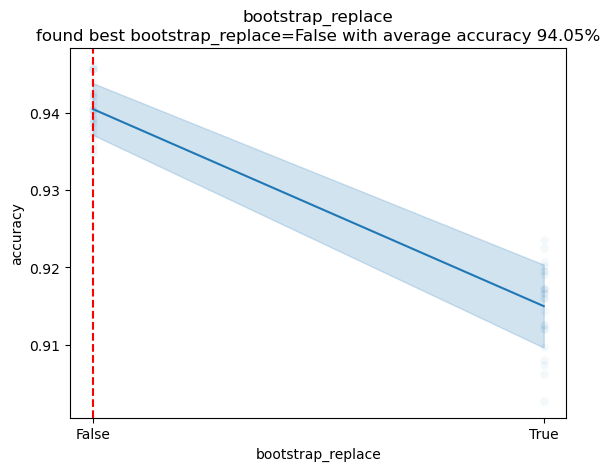

In [34]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, rf_constructor, 'bootstrap_replace', [False, True],
                           {'max_features': 6, 'n_estimators': 1, 'bootstrap_fraction': 1, 'sampling_temperature': 0, 'tree_kwargs': {'kind': 'c45', 'max_depth': 6, 'validation_ratio': 0 }},
                            reps=24, pool=pool)

Parametr `bootstrap_replace` określa, czy próbki są pobierane z powtórzeniami (True) czy bez (False) podczas tworzenia próbek bootstrap. Eksperyment z `bootstrap_replace` pokazuje malejącą dokładność, co sugeruje, że dla tego konkretnego zestawu danych wykorzystanie prób zastępczych (z powtórzeniami) może prowadzić do gorszych wyników.

Ten eksperyment został przeprowadzony na pojedyńczym drzewie C45 żeby pokazać z czego wynika różnica pomiędzy dokładnością lasu losowego z jednym drzewem z poprzedniego wykresu oraz pojedyńczego drzewa C4.5 z takimi samymi hiperparametrami.

### Bootstrap Fraction

Parametr `bootstrap_fraction` określa frakcję próbek danych, które są używane do generowania każdego drzewa. Wartości są wybierane losowo, z możliwością powtórzeń (jeżeli bootstrap_replace = True), co oznacza, że niektóre próbki mogą być wybierane więcej niż raz, podczas gdy inne mogą nie zostać wybrane wcale.

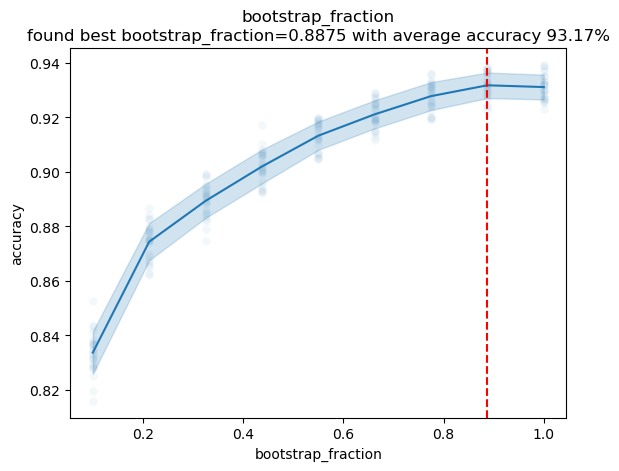

In [36]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, rf_constructor, 'bootstrap_fraction', np.linspace(0.1, 1, 9),
                           {'max_features': 6, 'n_estimators': 10, 'sampling_temperature': 0, 'tree_kwargs': {'kind': 'id3', 'max_depth': 5}},
                           reps=24, pool=pool)

Dla algorytmu ID3 z `max_features` równym 6 i `n_estimators` równym 10, najwyższa średnia dokładność (93.17%) została osiągnięta dla bootstrap_fraction równego 0.8875 (która jest bardzo podobna do 1 i może wynikac z odchylenia/bledu pomiaru eksperymentow). To sugeruje, że dla tego konkretnego modelu i zestawu danych, wykorzystanie prawie 89% oryginalnego zestawu danych do generowania każdego drzewa prowadzi do lepszych wyników, widać również odchylenie i od wartości 0.85 funkcja staje się stała. Można wywnioskować, że nawet wartość 1 mogłaby być dobra w ewaluacji modelu.

Jeślibyśmy użyli więkrzej liczby drzew (`n_estimators`) to spodziewamy się że optymalna wartość procentu danych do bootstrapingu mogłaby być mniejsza.

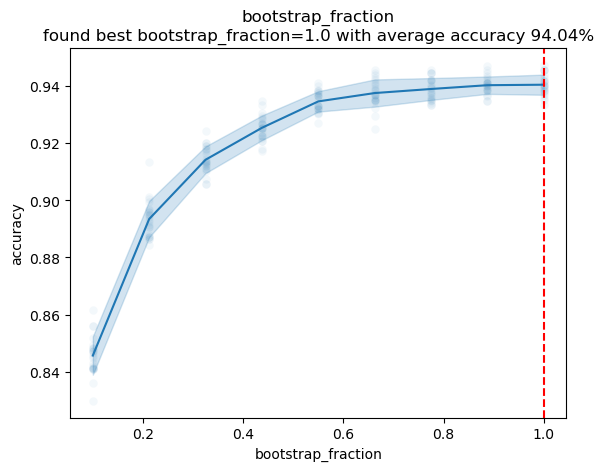

In [37]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, rf_constructor, 'bootstrap_fraction', np.linspace(0.1, 1, 9),
                           {'max_features': 6, 'n_estimators': 10, 'sampling_temperature': 0, 'tree_kwargs': {'kind': 'c45', 'max_depth': 6, 'validation_ratio': 0}},
                           reps=24, pool=pool),

Dla algorytmu C4.5 z `max_features` równym 6 i `n_estimators` równym 10, najwyższa średnia dokładność (94.04%) została osiągnięta dla bootstrap_fraction równego 1. Jest to inny wynik niż dla algorytmu ID3 i pokazuje, że optymalna frakcja bootstrappingu może się różnić w zależności od algorytmu i zestawu danych. Jednak podobnie zauważamy odchylenie, co może wnioskować ze wartości od 0.85 byłyby optymalne.

Różnice w kształcie tego wykresu dla ID3 i C4.5 (tzn. wykres dla C4.5 zaczyna rosnąć szybciej i szybciej osiąga "asymptote"), wynikają zapewne z tego że C4.5 inaczej przewiduje wartości dla próbek których atrybuty nie byly znalezione w zbiorze treningowym. Ten efekt jest bardziej widoczny, gdy zbiór treningowy jest mniejszy, tzn. więkrza liczba próbek będzie miała atrybuty których nie ma w drzewie.

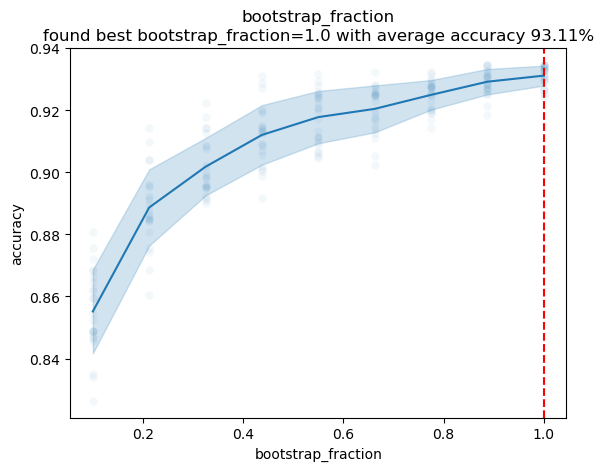

In [38]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, rf_constructor, 'bootstrap_fraction', np.linspace(0.1, 1, 9),
                           {'max_features': 6, 'n_estimators': 1, 'sampling_temperature': 0, 'tree_kwargs': {'kind': 'sklearn', 'max_depth': 6}},
                           reps=24, pool=pool)

Podobnie jak w przypadku poprzednich eksperymentów, analiza wartości parametru `bootstrap_fraction` dla lasu losowego używającego drzew decyzyjnych z konstruktora sklearn, z `max_features` równym 6 i `n_estimators` równym 1, daje najlepszy wynik (93.11%) dla `bootstrap_fraction` równego 1. 

To pokazuje, że dla tego konkretnego zestawu danych i ustawień modelu, wykorzystanie całego zestawu danych (100%) do generowania każdego drzewa daje najlepsze rezultaty. Oznacza to, że losowanie z powtórzeniami całego zestawu danych dla budowy pojedynczego drzewa w lesie przynosi największą dokładność klasyfikacji.

Wniosek jest taki, że dla różnych algorytmów drzew decyzyjnych (`id3`, `c45`, `sklearn`) i ich hiperparametrów, optymalna frakcja bootstrappingu może się różnić. Jednak dla wszystkich badanych przypadków wyższe wartości `bootstrap_fraction` dawały lepsze wyniki. Przy czym dla `id3` optymalna wartość wynosiła około 0.89, dla `c45` - 1, a dla `sklearn` - także 1 (dla jednego drzewa).

### Sampling Temperature

Jest to najważniejszy hiperparametr, który związany jest z tematem projektu, jego szczegołowa analiza potwierdzi poprawność mojego zaimplementowanego zmodyfikowanego Random Forest'a.

Parametr został szczegółowo opisany w implementacji algorytmu RandomForest powyżej w dokumentacji, na podstawie tego podam szczegółowe wnioski. 

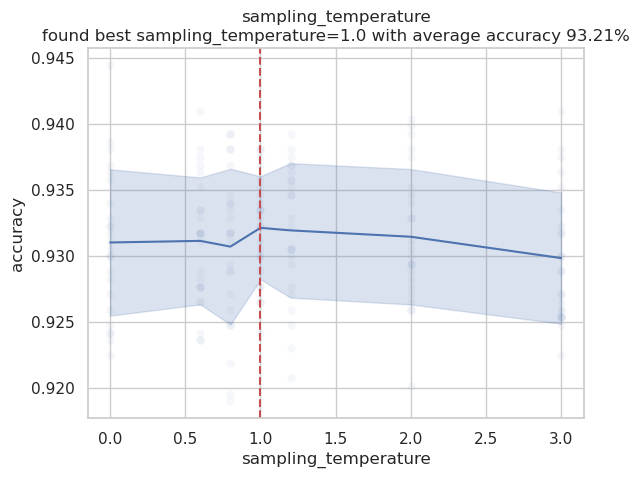

In [326]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, rf_constructor, 'sampling_temperature', [0., 0.6, 0.8, 1, 1.2, 2., 3.],
                           {'n_estimators': 10, 'max_features': 6, 'bootstrap_fraction': 0.8875, 'tree_kwargs': {'kind': 'id3', 'max_depth': 5}},
                           reps=24, pool=pool)

Analizując wyniki eksperymentu dla lasu losowego z wykorzystaniem algorytmu `id3` z `max_features` równym 6, `n_estimators` równym 10, `bootstrap_fraction` równym 0.8875 oraz różnymi wartościami `sampling_temperature`, można zauważyć, że najlepszy wynik (93.21% dokładności) został osiągnięty dla `sampling_temperature` równej 1.

`Sampling_temperature` równa 1 oznacza, że błędy popełniane przez model na zestawie out-of-bag są wykorzystywane bezpośrednio do wyznaczania prawdopodobieństw wyboru próbek. Innymi słowy, próbki, na których model popełnia większe błędy, mają większe szanse na wybór do nowych zestawów bootstrap (założenia projektu), co prowadzi do większej różnorodności drzew w modelu. 

Jednak wartość ta nie jest na tyle duża, aby wszystkie próbki były wybierane z równym prawdopodobieństwem (co miałoby miejsce dla bardzo dużych wartości `sampling_temperature`), ani na tyle mała, aby tylko próbki z największymi błędami były wybierane (co miałoby miejsce dla bardzo małych wartości `sampling_temperature`).

Wnioskując, dla tego konkretnego zestawu danych i ustawień modelu, nie możemy zdeterminować optymalnej wartości `sampling_temperature`, oraz czy ona wogole coś zmienia. Błędy pomiarów są za duże, m.in ponieważ zbiór danych jest za mały oraz zmiany nie wystarczająco duże.

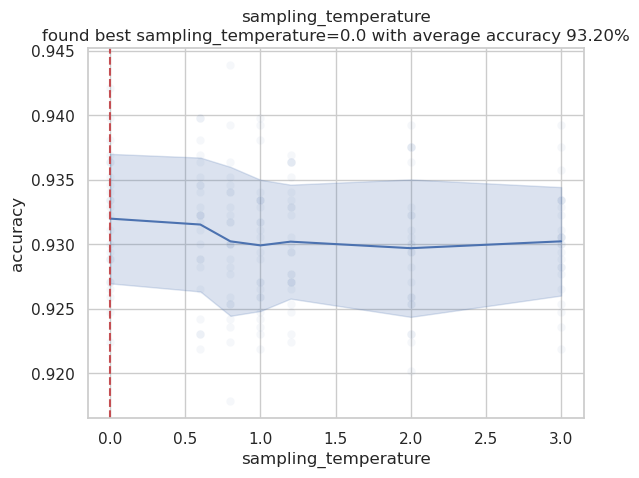

In [327]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, rf_constructor, 'sampling_temperature', [0., 0.6, 0.8, 1, 1.2, 2., 3.],
                           {'n_estimators': 80, 'max_features': 6, 'bootstrap_fraction': 0.8875, 'tree_kwargs': {'kind': 'id3', 'max_depth': 5}},
                           reps=24, pool=pool)

W przypadku lasu losowego z algorytmem id3, max_features równym 6, n_estimators równym 80, bootstrap_fraction równym 0.8875 i różnymi wartościami sampling_temperature, najwyższą dokładność (93.2%) osiągnięto dla sampling_temperature równej 0 (tzn. wszyskie próbki tak samo prawdopodobne). Znowu zmiana tego hiperparametru nie powoduje statystycznie istotnych zmian w wynikach modeli.

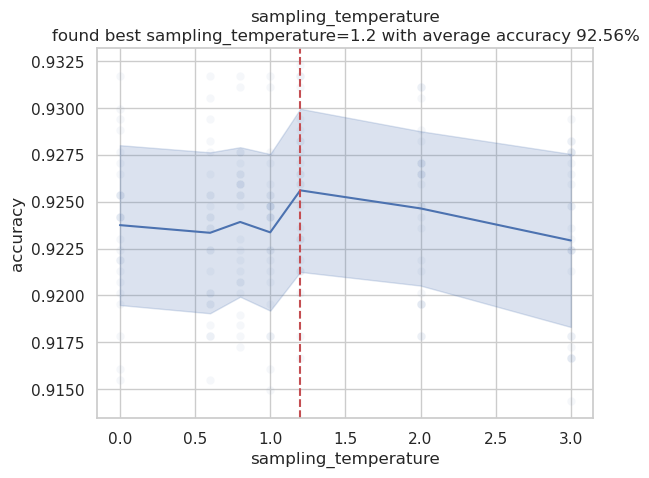

In [328]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, rf_constructor, 'sampling_temperature', [0., 0.6, 0.8, 1, 1.2, 2., 3.],
                           {'n_estimators': 10, 'max_features': 6, 'bootstrap_fraction': 1, 'tree_kwargs': {'kind': 'c45', 'max_depth': 6}},
                           reps=24, pool=pool)

W przypadku lasu losowego z algorytmem c45, max_features równym 6, n_estimators równym 10, bootstrap_fraction równym 1 wnioski są takie same jak poprzednio.

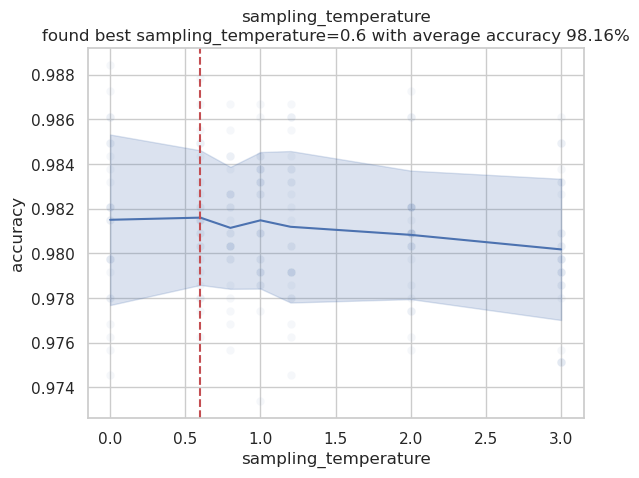

In [359]:
def rf_c45_continuous_constructor(tree_kwargs, random_seed, **kwargs):
    return RandomForest(**kwargs, random_seed=random_seed, tree_constructor=lambda: c45_constructor_continuous(**tree_kwargs, random_seed=random_seed))
with Pool(24) as pool:
    plot_factor_dependency(X, Y, rf_c45_continuous_constructor, 'sampling_temperature', [0., 0.6, 0.8, 1, 1.2, 2., 3.],
                           {'n_estimators': 10, 'max_features': 6, 'bootstrap_fraction': 0.8, 'tree_kwargs': {'max_depth': 12, 'validation_ratio': 0}},
                           reps=24, pool=pool)

W przypadku lasu losowego z algorytmem c45 ze zmiennymi traktowanymi jako ciągłe wnioski są takie same jak poprzednio.

## Gender DataSet


In [329]:
df2, columns = load_dataset('gender')
X2, Y2 = df2.drop(columns='target'), df2['target']

columns

{'long_hair': [0, 1],
 'nose_wide': [0, 1],
 'nose_long': [0, 1],
 'lips_thin': [0, 1],
 'distance_nose_to_lip_long': [0, 1]}

In [208]:
id3_args = {}
c45_args = {'validation_ratio': 0}

id3_args i c45_args to słowniki zawierające argumenty, które zostaną przekazane do konstruktorów algorytmów ID3 i C4.5. W tym przypadku id3_args jest pusty, co oznacza, że algorytm ID3 będzie używał domyślnych wartości argumentów, a c45_args ma jeden argument - validation_ratio ustawiony na 0. Argument validation_ratio określa, jaki procent danych ma zostać użyty jako zestaw walidacyjny podczas uczenia drzewa w algorytmie C4.5. Wartość 0 oznacza, że wszystkie dane będą używane do uczenia drzewa, a żadne do walidacji.

### Max Depth

Wykonane testy analizują wpływ głębokości drzewa (max_depth) na dokładność (accuracy) trzech różnych algorytmów drzew decyzyjnych: ID3, C4.5 oraz Scikit-learn Decision Tree.

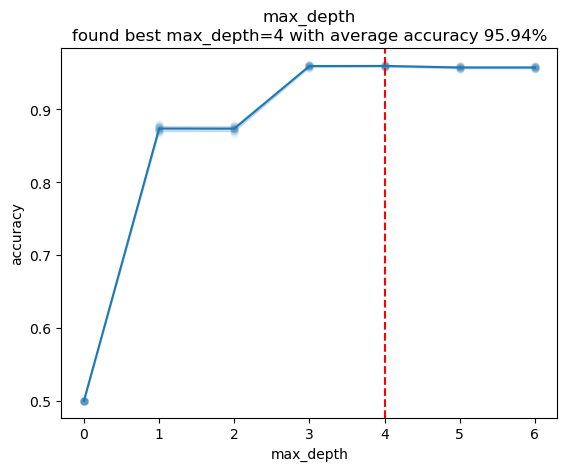

{'max_depth': 4}

In [209]:
with Pool(24) as pool:
    id3_args = plot_factor_dependency(X2, Y2, id3_constructor, 'max_depth', range(7), id3_args, reps=24, pool=pool)
id3_args

Algorytm ID3 osiągnął najwyższą dokładność 95.94% dla głębokości drzewa równego 4. Zwiększenie głębokości drzewa powyżej 4 nie przyniosło poprawy dokładności. Sugeruje to, że model jest wystarczająco złożony przy max_depth=4 i dodatkowe zwiększanie głębokości drzewa nie przynosi dodatkowych korzyści, a może prowadzić do nadmiernego dopasowania.

Zbiór ma 5 atrybutów kategorycznych (binarnych), więc interesujące jest że model nie poprawil sie z głębokości 4 do 5. Najprawdopodobnie wynika to z tego ze jeden atrybut nie użyteczny do predykcji klasy.

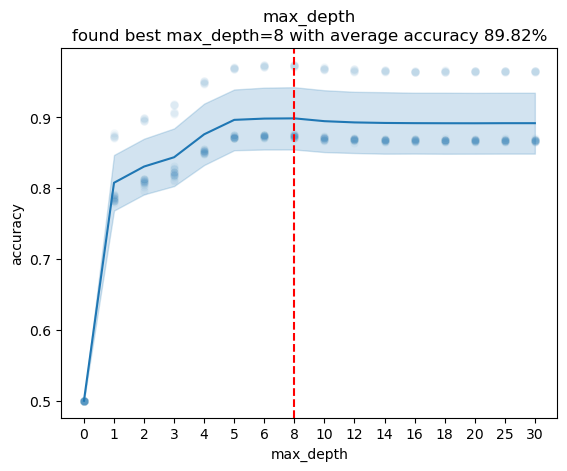

{'validation_ratio': 0, 'max_depth': 8}

In [210]:
with Pool(24) as pool:
    c45_args = plot_factor_dependency(X2, Y2, c45_constructor, 'max_depth', [0 , 1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 18, 20, 25, 30], c45_args, reps=24, pool=pool)
c45_args

Algorytm C4.5, mimo braku przycinania (wszystkie dane były używane do trenowania, validation_ratio=0), osiągnął niższą dokładność niż ID3, wynoszącą 89.82% dla głębokości drzewa 8. W tym przypadku również zwiększenie głębokości powyżej 8 nie poprawiło dokładności. Niska dokładność w porównaniu do ID3 może wynikać z różnic w algorytmach lub z faktu, że zestaw danych nie jest dobrze przystosowany do algorytmu C4.5. Jednak warto zaznaczyć, że na wykresie widać znaczne odchylenie, co może skutkować nawet osiągnieciu accuracy równego ID3. Ponadto od wartości głębokości 5 wartość accuracy jest stała, wzrost głębokości nie będzie miał wpływu na dalsze eksperymenty.

Ma sens że głębokość większa od liczby atrybutów zmienia model, jako że są tu tez atrybuty ciągłe, które mogą być użyte wielokrotnie z innymi threshold'ami.

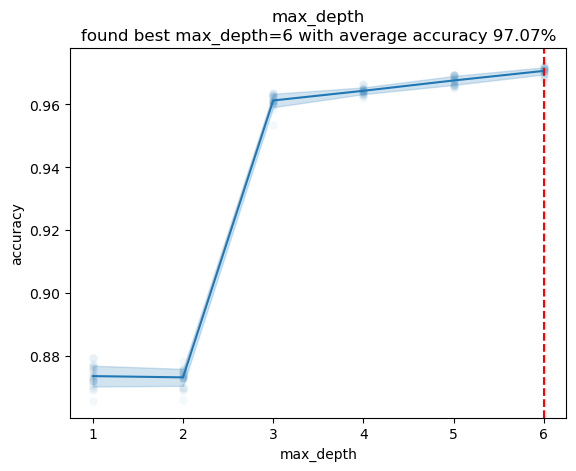

In [211]:
with Pool(24) as pool:
    plot_factor_dependency(X2, Y2, sklearn_constructor, 'max_depth', range(1, 7), {}, reps=24, pool=pool)

Algorytm Scikit-learn Decision Tree osiągnął najwyższą dokładność ze wszystkich testowanych algorytmów, wynoszącą 97.07% dla głębokości drzewa równego 6. Ten wynik sugeruje, że algorytm ten jest najbardziej efektywny dla analizowanego zestawu danych. Jednak w poprzednich modelach widać odchylenie standardowe, więc możemy wywnioskować że modele zostały dobrze zaimplementowane.

Różnica najprawdopodobniej wynika z innej funkcji podziału węzłów, tzn. model scikit-learnowy używa Gini Index, a mój C4.5 gain ratio.

### Validation ratio

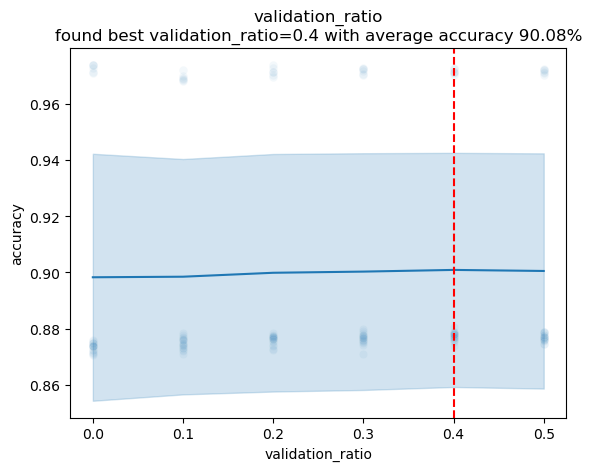

{'validation_ratio': 0.4, 'max_depth': 8}

In [212]:
with Pool(24) as pool:
    c45_args = plot_factor_dependency(X2, Y2, c45_constructor, 'validation_ratio', np.linspace(0, 0.5, 6), c45_args, reps=24, pool=pool)
c45_args

Wykres zależności "validation_ratio" dla algorytmu C4.5 pokazuje, że najwyższą dokładność modelu, wynoszącą 89.82%, osiągnięto dla validation_ratio=0.4

Parametr validation_ratio w algorytmie C4.5 kontroluje ilość danych używanych do przycinania drzewa, gdzie wyższa wartość oznacza, że większa część danych jest używana jako zestaw walidacyjny. W tym przypadku, użycie 40% danych do walidacji i przycinania drzewa dało najlepsze wyniki, jednakże nie jest to statystycznie istotne i tak naprawde wszystkie wartości są tak samo dobre.

In [213]:
rl_id3_args = {'max_features': 5, 'bootstrap_fraction': 1, 'sampling_temperature': 0, 'tree_kwargs': {'kind': 'id3', **id3_args}}
rl_c45_args = {'max_features': 5, 'bootstrap_fraction': 1, 'sampling_temperature': 0, 'tree_kwargs': {'kind': 'c45', **c45_args}}

### Number of estimators

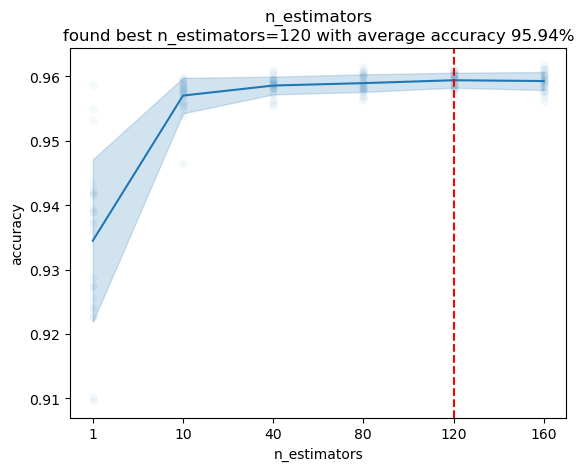

{'max_features': 5,
 'bootstrap_fraction': 1,
 'sampling_temperature': 0,
 'tree_kwargs': {'kind': 'id3', 'max_depth': 4},
 'n_estimators': 120}

In [214]:
with Pool(24) as pool:
    rl_id3_args = plot_factor_dependency(X2, Y2, rf_constructor, 'n_estimators', [1, 10, 40, 80, 120, 160], rl_id3_args, reps=24, pool=pool)
rl_id3_args

Po przeprowadzeniu analizy dla różnej liczby estymatorów ('n_estimators') dla algorytmu ID3 oraz C4.5 w kontekście lasów losowych, osiągnięto następujące wyniki:

Dla algorytmu ID3, najwyższa dokładność, wynosząca 95.94%, została osiągnięta dla 120 estymatorów. Oznacza to, że model lasu losowego skonstruowany z wykorzystaniem algorytmu ID3 osiąga najlepsze wyniki, gdy składa się z 120 drzew decyzyjnych. Jednak od wartości blisku 80 estymatorom widać, że funkcja jest stała, więc zwiększanie liczy estymatorów nie ma największego sensu, uwzgledniając również odchylenie.

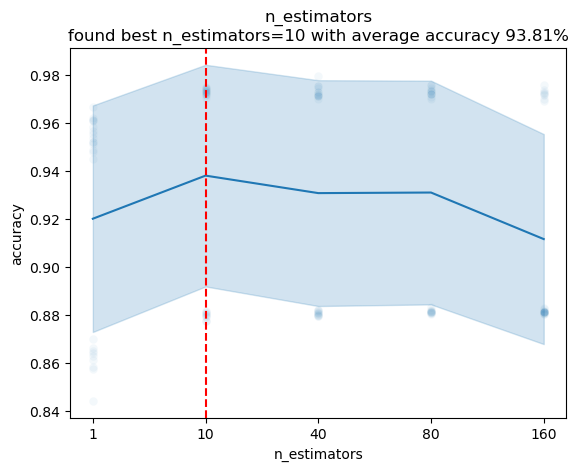

CPU times: user 476 ms, sys: 254 ms, total: 730 ms
Wall time: 1h 58min 10s


{'max_features': 5,
 'bootstrap_fraction': 1,
 'sampling_temperature': 0,
 'tree_kwargs': {'kind': 'c45', 'validation_ratio': 0.4, 'max_depth': 8},
 'n_estimators': 10}

In [215]:
%%time
with Pool(24) as pool:
    rl_c45_args = plot_factor_dependency(X2, Y2, rf_constructor, 'n_estimators', [1, 10, 40, 80, 160], rl_c45_args, reps=24, pool=pool)
rl_c45_args

Z kolei dla algorytmu C4.5, najwyższa dokładność, wynosząca 93.81%, została osiągnięta dla 10 estymatorów. Ten wynik sugeruje, że dla tego konkretnego zestawu danych oraz algorytmu, model osiąga najlepszą dokładność, gdy składa się tylko z 10 drzew decyzyjnych. Ponownie warto zaznaczyć, że w eksperymencie występuje duży szum/odchylenie, dlatego najbardziej optymalną opcją będzie wybranie większej liczby estymatorów.

Wnioskując, liczba estymatorów, czyli drzew decyzyjnych w modelu lasu losowego, jest istotnym parametrem wpływającym na dokładność modelu. Optymalna liczba drzew może zależeć od wielu czynników, takich jak algorytm używany do budowy drzew, charakterystyka danych, czy też parametry poszczególnych drzew. Jednakże, zbyt duża liczba drzew może prowadzić do nadmiernego dopasowania i niepotrzebnie zwiększać złożoność obliczeniową modelu. Dlatego ważne jest dobranie optymalnej liczby estymatorów, co można zrealizować poprzez proces walidacji krzyżowej i dostrajanie hiperparametrów.

Tak jak wcześniej pisałam, nie ma to sensu żeby więcej estymatorów miało gorszy wynik co potwierdza że jest to kwestia przypadku i dużego odchylenia.

### Max Features

Po analizie wpływu parametru 'max_features' na skuteczność modelu, osiągnięto następujące wyniki:

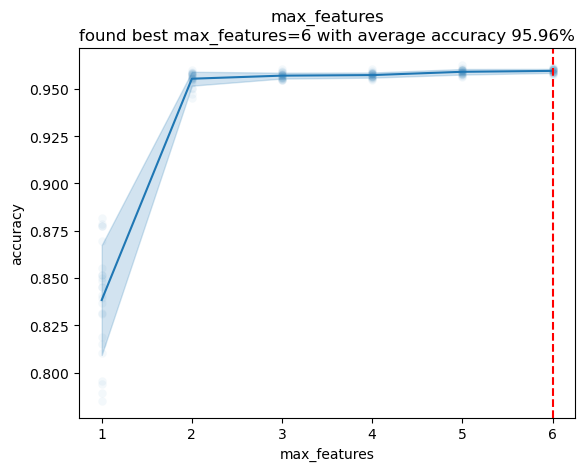

{'max_features': 6,
 'bootstrap_fraction': 1,
 'sampling_temperature': 0,
 'tree_kwargs': {'kind': 'id3', 'max_depth': 4},
 'n_estimators': 120}

In [216]:
with Pool(24) as pool:
    rl_id3_args = plot_factor_dependency(X2, Y2, rf_constructor, 'max_features', range(1,7), rl_id3_args, reps=24, pool=pool)
rl_id3_args

Dla algorytmu ID3, optymalna liczba cech do rozważenia przy każdym podziale wyniosła 5 (jest tylko 5 atrybutów dyskretnych, wiec model dla 5 i 6 jest identyczny), co przyniosło dokładność modelu na poziomie 95.96%. Oznacza to, że dla tego konkretnego modelu i zestawu danych, rozważanie wszystkich (dyskretnych) cech podczas każdego podziału drzewa decyzyjnego przyniosło najlepsze rezultaty.

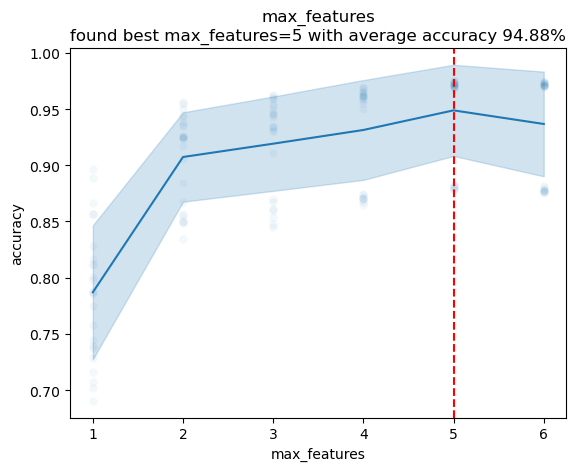

{'max_features': 5,
 'bootstrap_fraction': 1,
 'sampling_temperature': 0,
 'tree_kwargs': {'kind': 'c45', 'validation_ratio': 0.4, 'max_depth': 8},
 'n_estimators': 10}

In [217]:
with Pool(24) as pool:
    rl_c45_args = plot_factor_dependency(X2, Y2, rf_constructor, 'max_features', range(1, 7), rl_c45_args, reps=24, pool=pool)
rl_c45_args

Podobnie, dla algorytmu C4.5, model osiągnął najwyższą dokładność (94.88%) dla 'max_features' równych 5. To sugeruje, że dla tego algorytmu i zestawu danych, model osiąga najwyższą skuteczność, kiedy rozważa 5 cech przy każdym podziale, czyli tyle ile liczba cech w zbiorze.

Wniosek z tych analiz jest taki, że liczba cech do rozważenia przy każdym podziale drzewa decyzyjnego ('max_features') ma istotny wpływ na dokładność modelu lasu losowego. Nie zawsze większa liczba cech skutkuje lepszą skutecznością modelu, co jest zgodne z oczekiwanym zachowaniem - zbyt wiele cech może prowadzić do nadmiernego dopasowania (overfittingu), podczas gdy zbyt mała liczba może prowadzić do niedopasowania (underfittingu). Dlatego ważne jest dobranie optymalnej liczby cech, co można zrealizować poprzez proces walidacji krzyżowej i dostrajanie hiperparametrów.

Warto również zaznaczyć, że oba modele mają praktycznie podobne accuracy.

### Bootstrap fraction

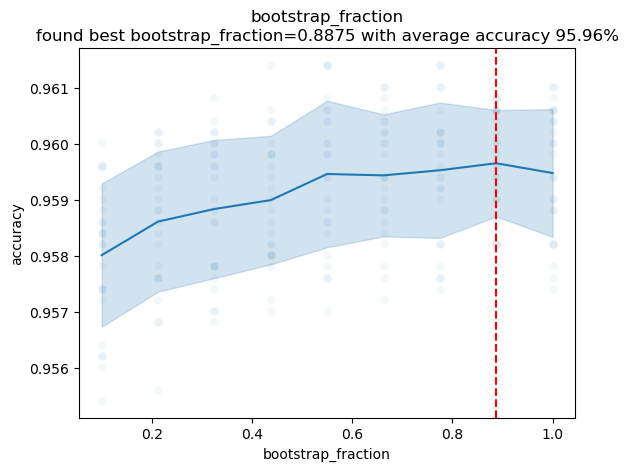

{'max_features': 6,
 'bootstrap_fraction': 0.8875,
 'sampling_temperature': 0,
 'tree_kwargs': {'kind': 'id3', 'max_depth': 4},
 'n_estimators': 120}

In [218]:
with Pool(24) as pool:
    rl_id3_args = plot_factor_dependency(X2, Y2, rf_constructor, 'bootstrap_fraction', np.linspace(0.1, 1, 9), rl_id3_args, reps=24, pool=pool)
rl_id3_args

W przypadku modelu opartego na algorytmie ID3, optymalna wartość bootstrap_fraction wyniosła 0.8875, co doprowadziło do osiągnięcia dokładności na poziomie 95.96%. To oznacza, że wybór około 88.75% próbek z pełnego zestawu danych do tworzenia każdego zestawu bootstrap przynosi najdokładniejsze wyniki dla tego modelu. Jednak znowu obserujemy szum/zakłócenia w stosunku do różnic (sam szum jest mały, na poziomie 0.1% (skala całego wykresu jest wąska)).

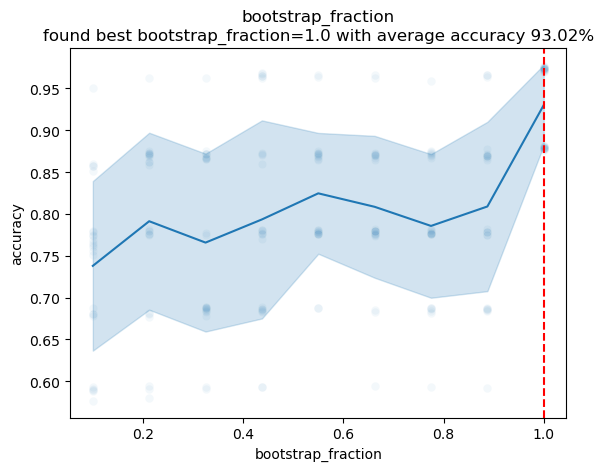

{'max_features': 5,
 'bootstrap_fraction': 1.0,
 'sampling_temperature': 0,
 'tree_kwargs': {'kind': 'c45', 'validation_ratio': 0.4, 'max_depth': 8},
 'n_estimators': 10}

In [219]:
with Pool(24) as pool:
    rl_c45_args = plot_factor_dependency(X2, Y2, rf_constructor, 'bootstrap_fraction', np.linspace(0.1, 1, 9), rl_c45_args, reps=24, pool=pool)
rl_c45_args

Dla modelu opartego na algorytmie C4.5, najlepszą dokładność (93.02%) osiągnięto dla bootstrap_fraction równego 1.0. W tym przypadku, dla każdego zestawu bootstrap wybierane są wszystkie próbki z pełnego zestawu danych.

Różnice w optymalnych wartościach bootstrap_fraction dla różnych algorytmów i zestawów danych pokazują, jak ważne jest dostosowanie hiperparametrów modelu do konkretnego zadania. Zbyt mała lub zbyt duża wartość bootstrap_fraction może prowadzić do nadmiernego lub niewystarczającego dopasowania modelu, co wpływa na jego zdolność do skutecznego przewidywania na nowych danych.

### Sampling Temperature

Jako najważniejszy hiperparametr użyty w eksperymentach.

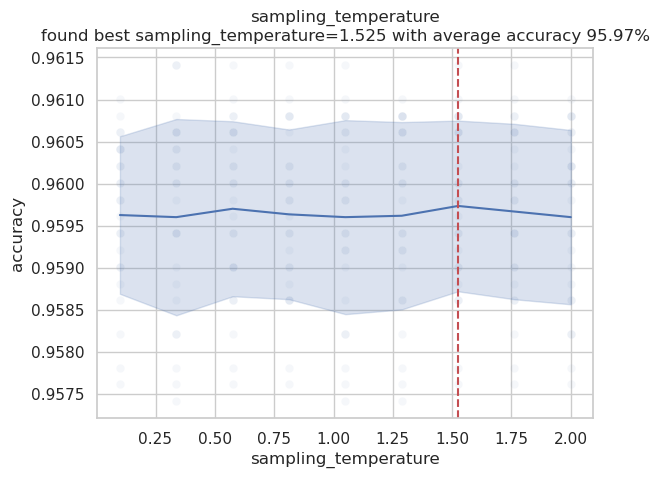

{'max_features': 6,
 'bootstrap_fraction': 0.8875,
 'sampling_temperature': 1.525,
 'tree_kwargs': {'kind': 'id3', 'max_depth': 4},
 'n_estimators': 120}

In [330]:
with Pool(24) as pool:
    rl_id3_args = plot_factor_dependency(X2, Y2, rf_constructor, 'sampling_temperature', np.linspace(0.1, 2, 9), rl_id3_args, reps=24, pool=pool)
rl_id3_args

Dla modelu opartego na algorytmie ID3, optymalna wartość sampling_temperature wynosiła 1.525. Wskazuje to, że umiarkowane "temperowanie" błędów modelu, prowadzi do stworzenia lepiej przewidujących drzew decyzyjnych. Takie drzewa skupiają się na próbkach, które są trudniejsze do klasyfikacji, co pomaga poprawić ogólną skuteczność modelu, co potwierdza osiągnięta dokładność wynosząca 95.96%. Potwierdza to słuszność poprawnej mojej implementacji algorytmu Random Foresta. Jednak znowu obserwujemy odchylenie na wykresie, co robi zdeterminowanie optymalnego parametru nie możliwe.

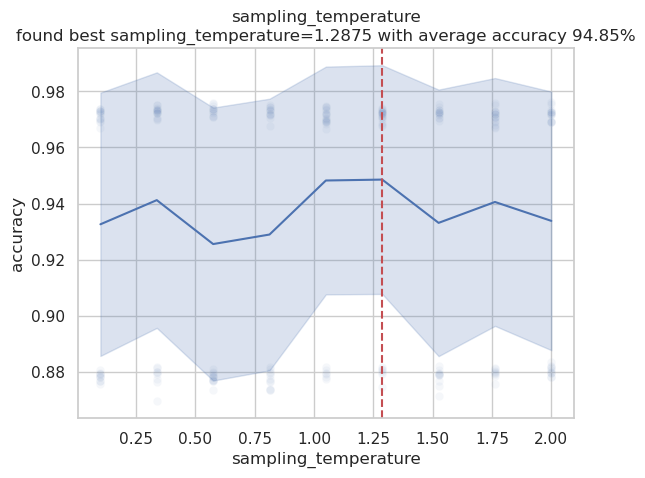

{'max_features': 5,
 'bootstrap_fraction': 1.0,
 'sampling_temperature': 1.2875,
 'tree_kwargs': {'kind': 'c45', 'validation_ratio': 0.4, 'max_depth': 8},
 'n_estimators': 10}

In [331]:
with Pool(24) as pool:
    rl_c45_args = plot_factor_dependency(X2, Y2, rf_constructor, 'sampling_temperature', np.linspace(0.1, 2, 9), rl_c45_args, reps=24, pool=pool)
rl_c45_args

Dla modelu opartego na algorytmie C4.5, najlepszą dokładność uzyskano dla sampling_temperature wynoszącej 1.2875. W tym przypadku, umiarkowane "temperowanie" błędów również prowadziło do skuteczniejszego modelu, choć nieznacznie mniej intensywnego niż w przypadku modelu ID3.

W obu przypadkach, umiarkowane temperowanie błędów modelu pomogło skoncentrować się na trudniejszych do klasyfikacji próbkach, co przyczyniło się do poprawy ogólnej skuteczności modelu.

# Niezrównowazony zbiór danych Gender (sztuczne zdysbalansowanie)

In [361]:
df3, columns = load_dataset('gender')
X3, Y3 = df3.drop(columns='target'), df3['target']

Poniżej zaimplementowałam funkcję o nazwie create_imbalanced_cv_split, której głównym zadaniem jest tworzenie nierównomiernie podzielonych zbiorów do walidacji krzyżowej.

Użyłam metody StratifiedKFold do zapewnienia, że klasy są równomiernie reprezentowane w każdym podziale. Dzięki temu, każdy podzbiór utworzony przez tę metodę zawiera odpowiednie przybliżenie całkowitego odsetka próbek każdej klasy.

Następnie, na podstawie parametru train_male_fraction, określiłam oczekiwaną proporcję próbek męskich w danych treningowych. W zależności od tej proporcji, dla każdego podziału treningowego obliczyłam docelową liczbę próbek męskich i żeńskich. Jeżeli train_male_fraction jest mniejszy niż 0.5, zredukowałam liczbę próbek męskich. W przeciwnym razie, zmniejszyłam liczbę próbek żeńskich.

Na końcu, wybrałam losowo odpowiednią liczbę próbek męskich i żeńskich z indeksów treningowych i połączyłam je, tworząc nowy, nierównomierny zbiór treningowy.

Cały proces powtarzałam dla każdego podziału generowanego przez StratifiedKFold i dodawałam te podziały do listy wynikowej. Ta lista podziałów, która jest zwracana przez moją funkcję, może być potem używana do przeprowadzenia walidacji krzyżowej na nierównomiernych danych.

Ten eksperyment ma na celu sztuczne stoworzenie "trudnych" próbek do klasyfikacji (jak będzie ich mało w treningu, to powinny byc trudniejsze przy ewaluacji). Zbiór danych walidacyjnych jest zawsze zabalansowany (50%-50%)

In [259]:
def create_imbalanced_cv_split(X, Y, train_male_fraction, random_state=0, n_splits=5):
    rng = np.random.RandomState(random_state)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rng)
    ret = []
    for train_idx, val_idx in skf.split(X, Y):
        train_male_idx = train_idx[Y[train_idx] == "Male"]
        train_female_idx = train_idx[Y[train_idx] == "Female"]
        target_male_count = len(train_male_idx)
        target_female_count = len(train_female_idx)
        if train_male_fraction < 0.5:
            target_male_count = round(target_female_count * train_male_fraction / (1 - train_male_fraction))
        else:
            target_female_count = round(target_male_count * (1 - train_male_fraction) / train_male_fraction)
            
        train_male_idx = rng.choice(train_male_idx, target_male_count, replace=False)
        train_female_idx = rng.choice(train_female_idx, target_female_count, replace=False)
        train_idx = np.concatenate([train_male_idx, train_female_idx])
            
        ret.append((train_idx, val_idx))
    return ret

In [271]:
def evaluate_model_imbalanced(X, Y, model_constructor, model_args, n_splits=5, verbose=True, imbalance_ratio=0.5):
    """
    Evaluates the imbalanced model using cross-validation and calculates accuracy.

    Parameters
    ----------
    X : DataFrame
        Features data.
    Y : Series
        Target data.
    model_constructor : callable
        Constructor for the model.
    model_args : dict
        Arguments for the model constructor.
    n_splits : int, optional
        The number of folds in the cross-validation, by default 5.
    verbose : bool, optional
        Whether to display extra output or not, by default True.

    Returns
    -------
    float
        Accuracy of the model.
    """
    preds = []
    gt = []
    
    for i, (train_indices, val_indices) in enumerate(
            create_imbalanced_cv_split(X, Y, imbalance_ratio, random_state=model_args['random_seed'], n_splits=n_splits)):
        model = model_constructor(**model_args)
        model.fit(X.iloc[train_indices], Y.iloc[train_indices])
        preds.append(model.predict(X.iloc[val_indices]))
        gt.append(Y.iloc[val_indices])

    preds = np.concatenate(preds)
    gt = np.concatenate(gt)
    if verbose:
        ConfusionMatrixDisplay.from_predictions(gt, preds, normalize="all")
    return (preds == gt).mean()

Poniższy kod prowadzi analizę wpływu różnych wartości parametru sampling_temperature dla klasyfikatora Random Forest (RF) na dane, które są nierównomiernie podzielone. Równocześnie analizuje różne poziomy nierównomierności danych, 0.01 i potem od 0.02 do 0.1, w 5 równych krokach.

0.01


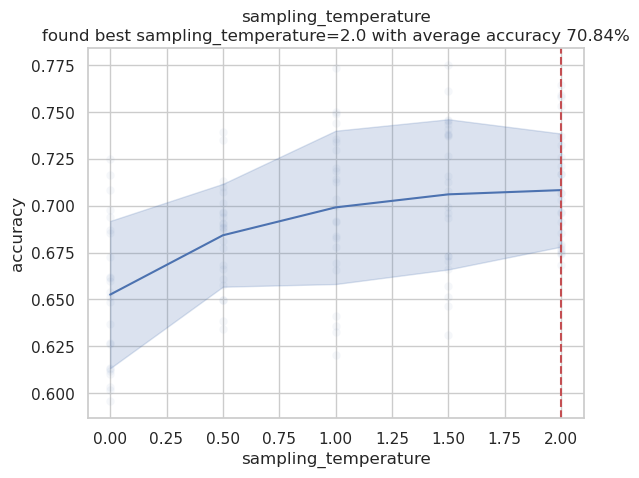

0.02


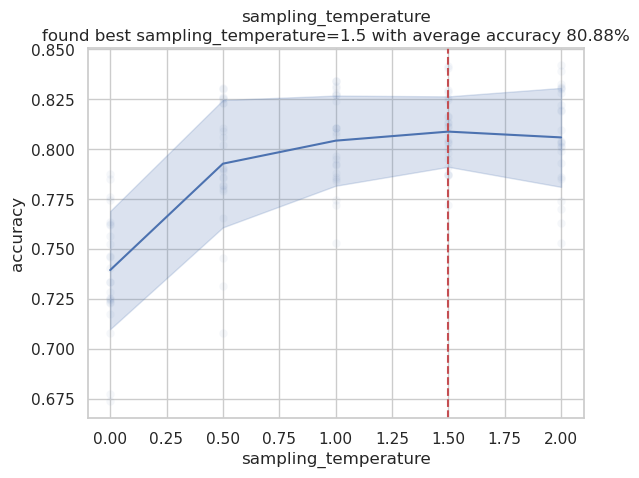

0.04


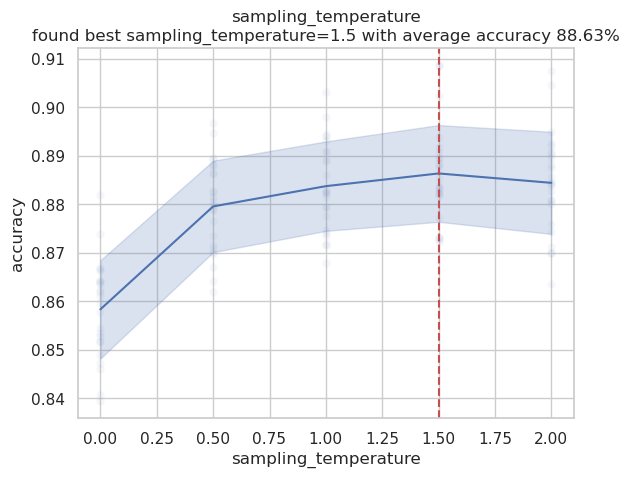

0.06


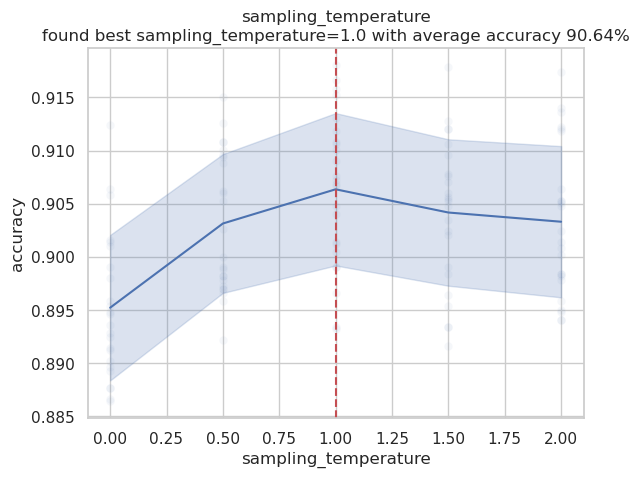

0.08


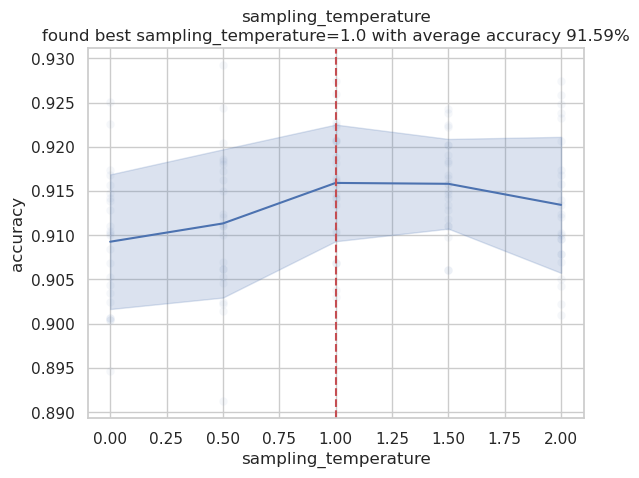

0.1


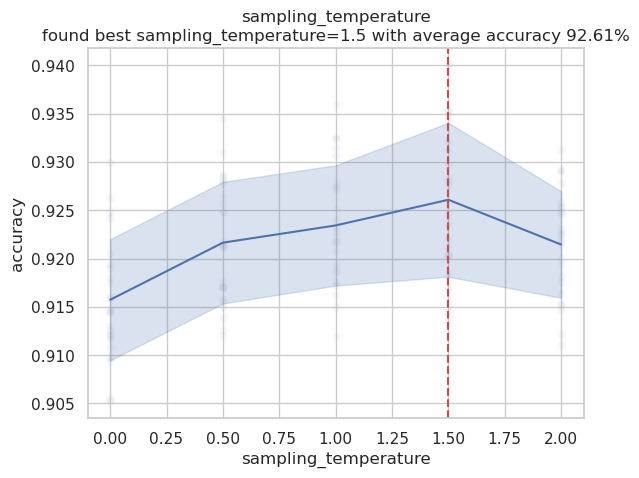

CPU times: user 1.82 s, sys: 458 ms, total: 2.27 s
Wall time: 7min 46s


In [364]:
%%time
with Pool(24) as pool:
    for imbalance in [0.01, 0.02, 0.04, 0.06, 0.08, 0.1]:
        print(imbalance)
        plot_factor_dependency(X3, Y3, rf_constructor, 'sampling_temperature', np.linspace(0, 2, 5),
                               { 'max_features': 5,
                                 'bootstrap_fraction': 0.5,
                                 'tree_kwargs': {'kind': 'sklearn', 'max_depth': 4},
                                 'n_estimators': 20,
                               },
                               reps=24, pool=pool, evaluate_model=partial(evaluate_model_imbalanced, imbalance_ratio=imbalance))

Interesujące tutaj jest, że `sampling_temperature` poprawia klasyfikacje tylko jeśli mamy bardzo duży imbalans klas (np. jedna klasa stanowi 2% lub 4% całego zbioru danych, a druga klasa reszte) (tak jak spekulowano w opisie eksperymentu).

Jednakże efekt wydaje sie byc mało istotny. Może to wynikać z tego jak działają drzewa decyzyjne. Tzn. jak algorytm znajdzie dobry atrybut do podziału to i tak może dobrze klasyfikować próbki klasy której bylo bardzo mało danych w treningowym zbiorze.

Żeby pokazać lepiej sens eksperymentu, pokaże to na lasie losowych który zamiast drzew ma regresje logistyczne. Ma to sens jako że predykcje regresja logistyczna są bardziej zależne od proporcji danych w zbiorze treningowym.

# Poprawność metody na klasyfikatorze regresji logistycznej 

W tym fragmencie kodu, zaimplementowałam analizę zależności wydajności klasyfikatora Random Forest (RF) od różnych wartości parametru sampling_temperature na danych o nierównomiernym podziale. Analiza ta jest przeprowadzana dla różnych poziomów nierównomierności danych (0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5). 0.01 znaczy że jedna klasa stanowi 1% wszystkich danych treningowych, a 0.5 znaczy że mamy balans klas.

Najważniejszą zmianą w porównaniu do poprzedniego kodu jest to, że drzewa decyzyjne, które są elementem lasu losowego, są tutaj tworzone przez model regresji logistycznej z pakietu sklearn.linear_model.

Podsumowując, w tym fragmencie kodu zaimplementowałam proces badania, jak różne poziomy nierównomierności danych wpływają na skuteczność modelu RF (z drzewami decyzyjnymi opartymi na regresji logistycznej) dla różnych wartości sampling_temperature.

0.01


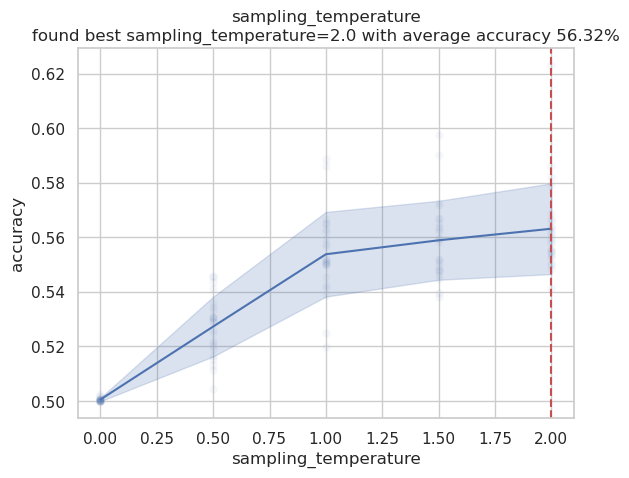

0.02


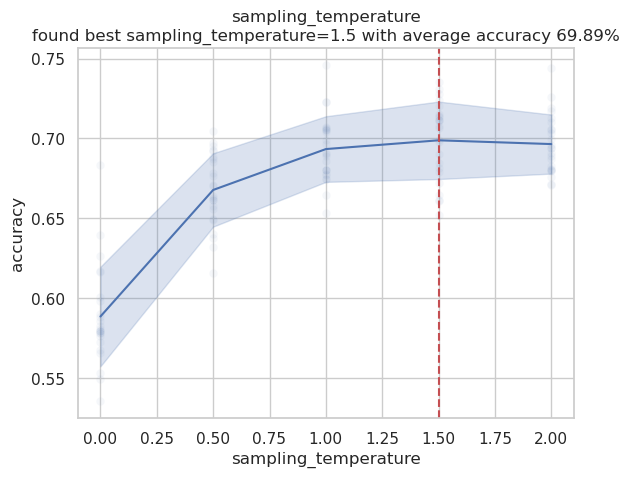

0.04


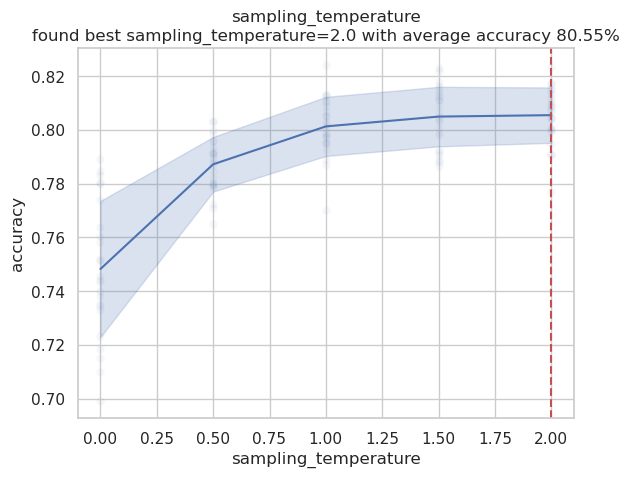

0.06


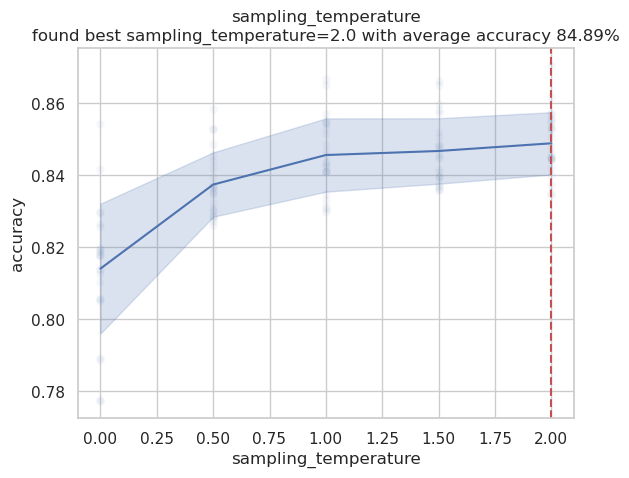

0.08


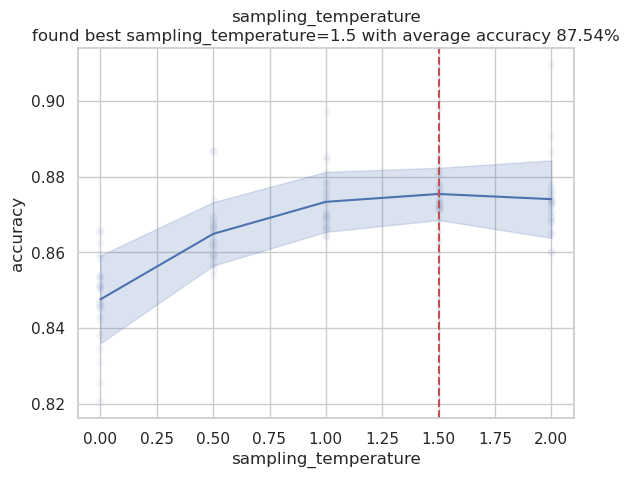

0.1


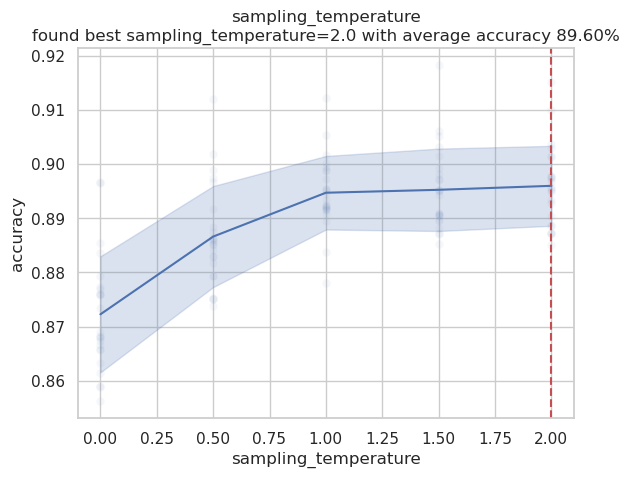

0.2


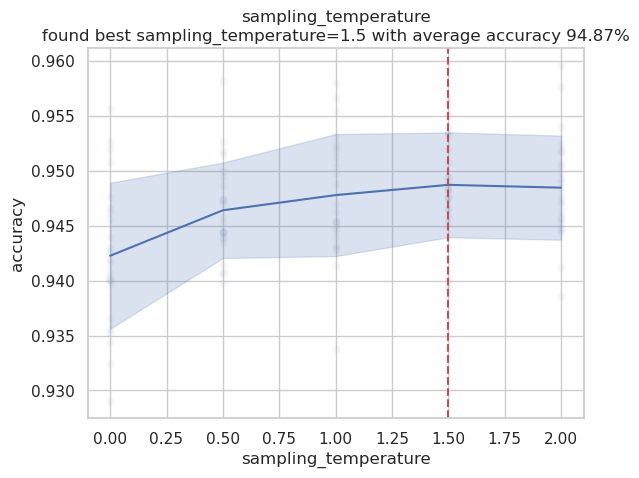

0.3


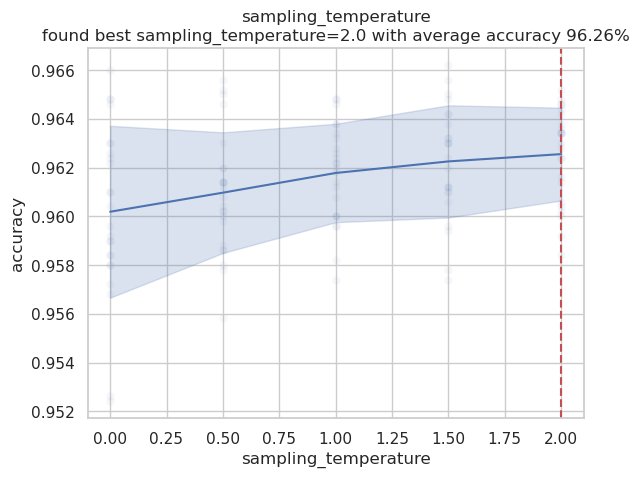

0.4


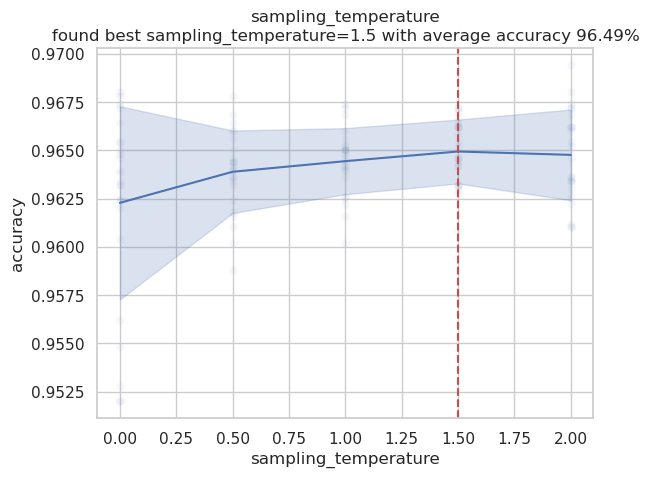

0.5


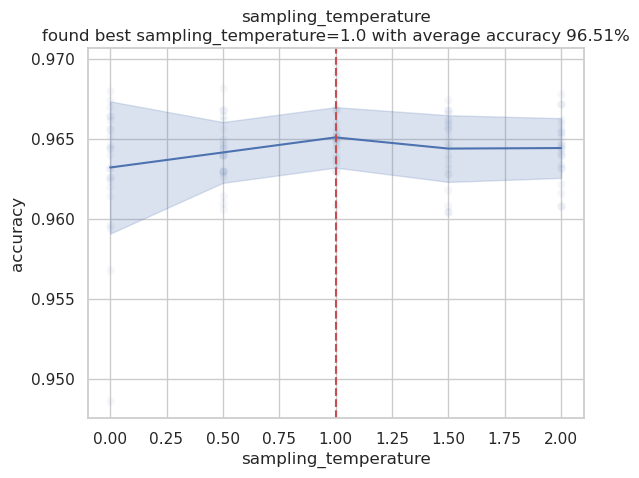

In [365]:
with Pool(24) as pool:
    for imbalance in [0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5]:
        print(imbalance)
        plot_factor_dependency(X3, Y3,
                               partial(RandomForest, tree_constructor=partial(SklearnModel, sklearn.linear_model.LogisticRegression, discrete_feature_order=columns)),
                                'sampling_temperature', np.linspace(0, 2, 5),
                               { 'max_features': 4,
                                 'bootstrap_fraction': 0.5,
                                 'n_estimators': 20,
                               },
                               reps=24, pool=pool, evaluate_model=partial(evaluate_model_imbalanced, imbalance_ratio=imbalance))

Analizując wyniki eksperymentu, zauważam, że wartość parametru 'sampling_temperature' znacznie wpływa na skuteczność klasyfikatora w kontekście danych o nierównomiernej dystrybucji. Zauważam, że wraz ze wzrostem nierównomierności (imbalance) danych, zwiększa się dokładność klasyfikatora dla wyższych wartości 'sampling_temperature'. Najlepsze wyniki są uzyskiwane dla 'sampling_temperature' równego 1.5 lub 2, w zależności od stopnia nierównowagi. Im mniejszy imbalans, tym efekt z `sampling_temperature` jest mniej istotny.

Podsumowując:

Analiza tych wyników pokazuje, że dostosowanie 'sampling_temperature' może poprawić wydajność klasyfikatora na danych o nierównomiernym rozkładzie. Ten wynik potwierdza sensowność eksploracji tego parametru w kontekście takich danych.

Co do poprawności implementacji, to wszystko wygląda na prawidłowe. Kod skutecznie przeprowadza analizę dla różnych wartości 'sampling_temperature' i różnych stopni nierównowagi w danych. Zastosowanie regresji logistycznej jako podstawy do budowy drzew w lesie losowym również jest ciekawym i sensownym podejściem, które potencjalnie może lepiej radzić sobie z niezbalansowanymi danymi, w porówaniu z moją implementacją na drzewach decyzyjnych.

Wnioski:

Regresja logistyczna, w przeciwieństwie do drzew decyzyjnych, jest modelem stochastycznym, który szacuje prawdopodobieństwa przynależności do danej klasy, a nie dokonuje bezpośredniej klasyfikacji. To pozwala na bardziej subtelne dostosowanie do danych, szczególnie gdy są one niezbalansowane, co przedstawiłam w poprzednim eksperymencie.

Dlatego też dla regresji logistycznej widać większy wpłów w ważeniu błędnie klasyfikowanych próbek w ensemblingu estymatorów.

Jednakże to nie jest reguła! To jest charakterystyka tych zbiorów danych i w innych zbiorach danych może być inaczej i może to być widocznie też na drzewach, i nie byc na regresji logistycznej.

Zauważmy że imbalans klas jest jednym z przykladów gdzie ważenie próbek daje przewage. Innym przykladem mógłby być zbiór danych gdzie jedna klasa jest istotnie trudniejsza od innych, nawet gdy zbiór bylby zbalansowany. Co więcej, może to działać też dla sytuacji gdzie tylko specyficzna część danych jest trudna a nie cała klasa. W takich przypadkach można spekulować że las losowy "na drzewach" mógłby mieć przewage przy większych `sampling_temperature` niż regresje logistyczne.

Niestety nie jesteśmy zbadać tej hipotezy na tych zbiorach danych. Zaletą tego algorytmu jest to że powinnien on sie sam dostosować do sytuacji i generalnie nie wymaga ręcznego dostosowywania w zależności od przypadku. Zauważmy też że **nigdzie** w moich eksperymentach dodatni `sampling_temperature` nie pogorszył wyniku algorytmu (w najgorszym przypadku nie przyniósł żadnych zmian).

### Calculate Macro Accuracy 

In [7]:
def macro_accuracy(ground_truth, y_pred):
    cm = confusion_matrix(ground_truth, y_pred)
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    macro_accuracy = np.mean(class_accuracies)
    
    return macro_accuracy

## Evaluate model on best hyperparameters

In [367]:
df, columns = load_dataset('car')
X, Y = df.drop(columns='target'), df['target']

temperature: 0


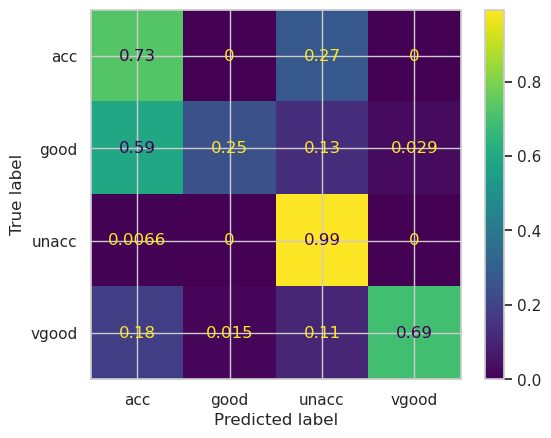

temperature: 0.5


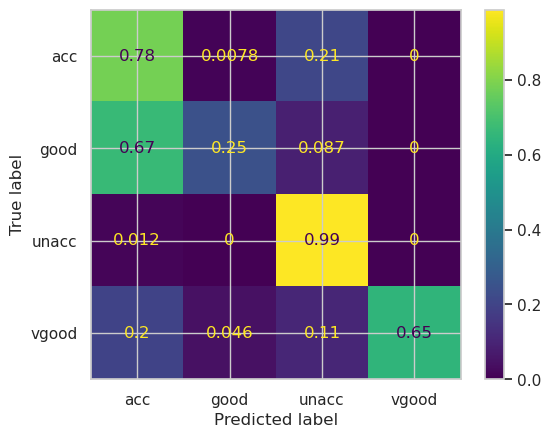

temperature: 1


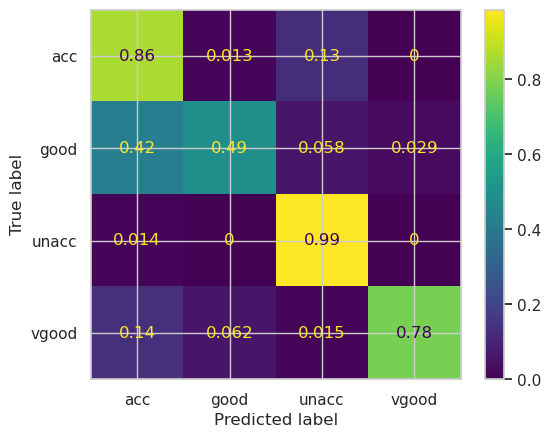

temperature: 2


In [ ]:
for temp in [0, 0.5, 1, 2]:
    print('temperature:', temp)
    evaluate_model(X, Y, rf_constructor, {'n_estimators': 80, 'max_features': 5, 'tree_kwargs': {'kind': 'id3', 'max_depth': 5}, 'bootstrap_fraction': 0.8,
                                         'sampling_temperature': temp, 'random_seed': 42})
    plt.show()

0.9299768518518519

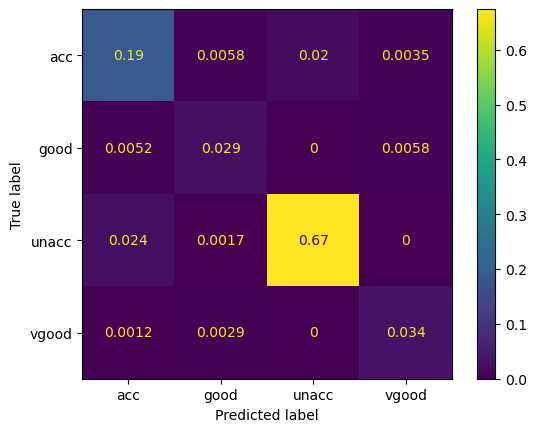

In [62]:
evaluate_model(X, Y, rf_constructor, {'n_estimators': 10, 'max_features': 6, 'tree_kwargs': {'kind': 'id3', 'max_depth': 5}, 'bootstrap_fraction': 0.8875,
                                     'sampling_temperature': 2, 'random_seed': 42})

0.9120370370370371

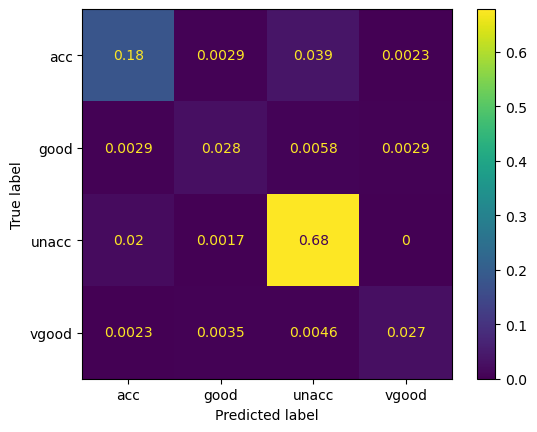

In [63]:
evaluate_model(X, Y, rf_constructor, {'n_estimators': 10, 'max_features': 6, 'tree_kwargs': {'kind': 'c45', 'max_depth': 10}, 'bootstrap_fraction': 1,
                                     'sampling_temperature': 2, 'random_seed': 42})

### Show Report

In [8]:
def show_report(data: Dict[str, np.ndarray], dfname: str, name=""):
    """
    data[split_name] -> (ground_truth, predictions)
    where ground_truth and predictions have shape either (num_reps x num_samples) or (num_samples)
    Plots confusion matrix and bar plot(contains metrics and values of them) 
    """
    # map ground truths and predictions to 2d np.array if they are 1d.
    data = {k: tuple(map(lambda v: (v if len(v.shape) == 2 else v.reshape(1, -1)), vs)) for k, vs in data.items()}
    
    plt.figure(figsize=(20, 5 * len(data)))
    plt.suptitle(name)
    
    for i, (split, (ground_truth, preds)) in enumerate(data.items()):
        ax = plt.subplot(len(data), 2, 1 + 2 * i)
        plt.title(split)
        ConfusionMatrixDisplay.from_predictions(ground_truth.reshape(-1), preds.reshape(-1), normalize="all", ax=ax)
    
    plt.subplot(1, 2, 2)
    if dfname == "gender":
        metrics = [
        (accuracy_score, "accuracy"),
        (lambda *args: macro_accuracy(*args), "macro_accuracy"),
        # (lambda *args: precision_score(*args, pos_label=["Female", "Male"]), "precision"),
        # (lambda *args: recall_score(*args, pos_label=["Female", "Male"]), "recall"),
        # (lambda *args: f1_score(*args, pos_label=["Female", "Male"]), "f1"),
    ]
    if dfname == "car":
        metrics = [
            (accuracy_score, "accuracy"),
            (lambda *args: macro_accuracy(*args), "macro_accuracy"),
        ]

    df = pd.DataFrame.from_dict(
        {
            "value": [
                metric(gt[i], preds[i])
                for metric, _ in metrics
                for split, (gt, preds) in data.items()
                for i, _ in enumerate(gt)
            ],
            "split": [split for _, _ in metrics for split, (gt, _) in data.items() for _ in gt],
            "metric": [metric_name for _, metric_name in metrics for _, (gt, _) in data.items() for _ in gt],
        }
    )
    sns.barplot(df, x="metric", y="value", hue="split", errorbar='sd')

    plt.show()